Point of Contact: Abigayle Hodson, Lawrence Berkeley National Laboratory (Abigayle_Hodson@lbl.gov)

Date of Last Revision: 12/9/2025

Overview: The purpose of this script is to leverage WaterTAP, an open-source, technoeconomic assessment (TEA) platform, to compare the energy consumption and cost of ultraviolet advanced oxidation process (UV AOP) technologies for premise-scale potable reuse.  More specifically, we compare the performance of standard, low-pressure (LPUV) mercury lamps to that of novel, krypton chloride excimer (KrCl*) lamps within an existing non-potable reuse treatment train in San Francisco, CA (Project 1550). Using experimentally-determined rate constants for 0.5 log reduction of 1,4-dioxane, the standard for potable reuse in California, and N-Nitrosodimethylamine (NDMA), we model the specific energy consumption and levelized cost of water (LCOW) necessary to meet potable reuse standards in through recycling greywater in this building. We compare technology performance across four different doses of hydrogen peroxide (H2O2) (0 - 9 mg/L), as well as two treatment train configurations: a simplified scenario in which a single reactor is assumed capable of delivering the required UV fluence, and a more realistic scenario in which multiple UV reactors in series deliver the required UV fluences. Considering that the LPUV lamp currently in use at Project 1550 which is modeled herein is designed for disinfection, we also model the specific energy consumption and LCOW of acheiving potable reuse standards using a TrojanUVPhox, a commercial-grade UV AOP designed for potable reuse.

### Define functions to initialize and solve UV-AOP models

In [37]:
#import classes and functions from Pyomo optimization library
import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Objective, Expression, value

#import flowsheet block from IDAES core
from idaes.core import FlowsheetBlock

#import function to link units in a flowsheet
from pyomo.network import Arc

#import function to get default solver
from watertap.core.solvers import get_solver

#import function to check degrees of freedom
from idaes.core.util.model_statistics import degrees_of_freedom

#import function for calculating scaling factors
from idaes.core.util.scaling import calculate_scaling_factors, set_scaling_factor

#import function to propagate state
from idaes.core.util.initialization import propagate_state

#import property models for each contaminant analyzed herein (1,4-dioxane and NDMA)
from watertap.property_models.unit_specific.dioxane_prop_pack import DioxaneParameterBlock
from watertap.property_models.unit_specific.NDMA_prop_pack import NDMAParameterBlock

#import costing model
from watertap.costing import WaterTAPCosting
from idaes.core import UnitModelCostingBlock

#import parameter sweep function for sensitivity analysis
from parameter_sweep import parameter_sweep, LinearSample

#import other libraries for data manipulation and visualization
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
import pandas as pd
import seaborn as sns
import numpy as np
import math

In [21]:
def basic_uv_aop_setup(m, reactor_num, tea_scenario, lamp_type, contaminant_type, dose_override=None):
    """Function that adds a UV-AOP reactor to flowsheet model
    Args: 
        m (ConcreteModel): Pyomo concrete model to which the UV-AOP unit model will be added
        reactor_num (int): reactor identification number, used to track multiple reactors in series
        tea_scenario (int): modeling scenario which specifies oxidant dose, options include 1 (0 mg/L H2O2), 2 (3 mg/L H2O2), 3 (6 mg/L H2O2), or 4 (9 mg/L H2O2)
        lamp_type (str): type of UV lamp used, options include 'LPUV' (VIQUA PRO 30 low-pressure mercury lamp, 254-nm), 'KrCl*' (krypton chloride excimer lamp, 222-nm), or 'Alt-LPUV' (TrojanUVPhox, 254-nm)
        contaminant_type (str): target contaminant being treated, either '1,4-dioxane' or 'NDMA'
        dose_override (float, optional): UV dose [J/m2] to override default for each scenario; toggled on when analyzing multiple reactors in series
    Returns:
        m (ConcreteModel): Pyomo concrete model with added UV AOP unit model
        total_dose (float): Target UV dose [J/m2] required for 0.5 log removal of 1,4-dioxane
    """
    #set flow rate and reactor volume as global variables
    global flow_rate, reactor_volume
    
    #name the reactor based on its ID number
    reactor_name = f"unit_{reactor_num}"

    #import UV-AOP model based on lamp type
    if lamp_type == 'LPUV':
        from watertap.unit_models.uv_aop_viqua import (Ultraviolet0D, MaterialBalanceType, EnergyBalanceType, MomentumBalanceType, UVDoseType, useDefault)
    elif lamp_type == 'KrCl*':
        from watertap.unit_models.uv_aop_KrCl import (Ultraviolet0D, MaterialBalanceType, EnergyBalanceType, MomentumBalanceType, UVDoseType, useDefault)
    elif lamp_type == 'Alt-LPUV': #note, costing information needs to be updated for TrojanUVPhox system
        from watertap.unit_models.uv_aop_trojan import (Ultraviolet0D, MaterialBalanceType, EnergyBalanceType, MomentumBalanceType, UVDoseType, useDefault)

    #add UV-AOP unit to the flowsheet; AOP argument is marked false to circumvent the need for developing indirect/direct photoloysis rate constants
    setattr(m.fs, reactor_name, Ultraviolet0D(
        dynamic=False,
        has_holdup=False,
        material_balance_type=MaterialBalanceType.useDefault,
        energy_balance_type=EnergyBalanceType.useDefault,
        momentum_balance_type=MomentumBalanceType.pressureTotal,
        property_package=m.fs.properties,
        has_pressure_change=False,
        uv_dose_type=UVDoseType.fixed,
        has_aop=False,
        target_species=None
    ))

    #access the newly created UV AOP unit using the dynamic name
    reactor = getattr(m.fs, reactor_name)

    #specify feed conditions for the first reactor
    flow_rate = 163.2/24/60/60 #[m3/s], based capacity of LPUV lamp used in Project 1550
    if reactor_num == 1: 
        reactor.inlet.temperature.fix(273.15 + 25) #temperature at inlet [degrees K]
        reactor.inlet.pressure.fix(101325) #pressure at inlet [Pa]
        reactor.outlet.pressure.fix(101325) #pressure at outlet [Pa]
        reactor.inlet.flow_mass_phase_comp[0, 'Liq', 'H2O'].fix(flow_rate*1000) #mass flow rate of water [kg/s]
        match contaminant_type:
            case '1,4-dioxane':
                reactor.inlet.flow_mass_phase_comp[0, "Liq", "Dioxane"].fix(influent_cnc*1000*flow_rate/(10**6)/1000) #mass flow rate of 1,4-dioxane [kg/s]
            case 'NDMA':
                reactor.inlet.flow_mass_phase_comp[0, "Liq", "NDMA"].fix(influent_cnc*1000*flow_rate/(10**6)/1000) #mass flow rate of NDMA [kg/s]

    #specify UV dose and inactivation rate required to acheive 0.5 log removal of 1,4-dioxane based on lamp type and hydrogen peroxide dose, as well as lamp efficiency and reactor volume and reactor volume
    match lamp_type:
        case 'LPUV':    
            reactor.lamp_efficiency.fix(0.375) #lamp efficiency [%]; how much power is converted to usable UV radiation
            reactor_volume = 0.0081 #[m3], based on volume of UV reactor used in Project 1550
            match tea_scenario:
                case 1:
                    total_dose = 173920 #experimentally-determined UV dose [J/m2] needed for 0.5 log removal of 1,4-dioxane at 0 mg/L H2O2
                    reactor.inactivation_rate.fix(6.61e-6) #experimentally-determined inactivation rate constant for 1,4-dioxane [m2/J]; represents combined degredation from direct and indirect photolysis
                case 2:
                    total_dose = 39390 #experimentally-determined UV dose [J/m2] needed for 0.5 log removal of 1,4-dioxane at 3 mg/L H2O2
                    reactor.inactivation_rate.fix(2.92e-5) #experimentally-determined inactivation rate constant for 1,4-dioxane [m2/J]; represents combined degredation from direct and indirect photolysis
                case 3:
                    total_dose = 22320 #experimentally-determined UV dose [J/m2] needed for 0.5 log removal of 1,4-dioxane at 6 mg/L H2O2
                    reactor.inactivation_rate.fix(5.15e-5) #experimentally-determined inactivation rate constant for 1,4-dioxane [m2/J]; represents combined degredation from direct and indirect photolysis
                case 4:
                    total_dose = 16690 #experimentally-determined UV dose [J/m2] needed for 0.5 log removal of 1,4-dioxane at 9 mg/L H2O2
                    reactor.inactivation_rate.fix(6.89e-5) #experimentally-determined inactivation rate constant for 1,4-dioxane [m2/J]; represents combined degredation from direct and indirect photolysis
        case 'KrCl*':
            reactor.lamp_efficiency.fix(0.06) #lamp efficiency [%]; how much power is converted to usable UV radiation
            reactor_volume = 0.0081 #[m3], based on volume of UV reactor used in Project 1550
            match tea_scenario:
                case 1:
                    total_dose = 6630 #experimentally-determined UV dose [J/m2] needed for 0.5 log removal of 1,4-dioxane at 0 mg/L H2O2
                    reactor.inactivation_rate.fix(1.73e-4) #experimentally-determined inactivation rate constant for 1,4-dioxane [m2/J]; represents combined degredation from direct and indirect photolysis
                case 2:
                    total_dose = 5460 #experimentally-determined UV dose [J/m2] needed for 0.5 log removal of 1,4-dioxane at 3 mg/L H2O2
                    reactor.inactivation_rate.fix(2.11e-4) #experimentally-determined inactivation rate constant for 1,4-dioxane [m2/J]; represents combined degredation from direct and indirect photolysis
                case 3:
                    total_dose = 5640 #experimentally-determined UV dose [J/m2] needed for 0.5 log removal of 1,4-dioxane at 6 mg/L H2O2
                    reactor.inactivation_rate.fix(2.04e-4) #experimentally-determined inactivation rate constant for 1,4-dioxane [m2/J]; represents combined degredation from direct and indirect photolysis
                case 4:
                    total_dose = 4700 #experimentally-determined UV dose [J/m2] needed for 0.5 log removal of 1,4-dioxane at 9 mg/L H2O2
                    reactor.inactivation_rate.fix(2.45e-4) #experimentally-determined inactivation rate constant for 1,4-dioxane [m2/J]; represents combined degredation from direct and indirect photolysis
        case 'Alt-LPUV':            
            reactor.lamp_efficiency.fix(0.35) #lamp efficiency [%]; how much power is converted to usable UV radiation
            reactor_volume = 0.085 #[m3], based on volume of UV reactor used in Orange County Sanitation District's TrojanUVPhox system
            match tea_scenario:
                case 1:
                    total_dose = 173920 #experimentally-determined UV dose [J/m2] needed for 0.5 log removal of 1,4-dioxane at 0 mg/L H2O2
                    reactor.inactivation_rate.fix(6.61e-6) #experimentally-determined inactivation rate constant for 1,4-dioxane [m2/J]; represents combined degredation from direct and indirect photolysis
                case 2:
                    total_dose = 39390 #experimentally-determined UV dose [J/m2] needed for 0.5 log removal of 1,4-dioxane at 3 mg/L H2O2
                    reactor.inactivation_rate.fix(2.92e-5) #experimentally-determined inactivation rate constant for 1,4-dioxane [m2/J]; represents combined degredation from direct and indirect photolysis
                case 3:
                    total_dose = 22320 #experimentally-determined UV dose [J/m2] needed for 0.5 log removal of 1,4-dioxane at 6 mg/L H2O2
                    reactor.inactivation_rate.fix(5.15e-5) #experimentally-determined inactivation rate constant for 1,4-dioxane [m2/J]; represents combined degredation from direct and indirect photolysis
                case 4:
                    total_dose = 16690 #experimentally-determined UV dose [J/m2] needed for 0.5 log removal of 1,4-dioxane at 9 mg/L H2O2
                    reactor.inactivation_rate.fix(6.89e-5) #experimentally-determined inactivation rate constant for 1,4-dioxane [m2/J]; represents combined degredation from direct and indirect photolysis
    
    #override inactivation rate, if analyzing NDMA degredation
    if contaminant_type == 'NDMA':
        match lamp_type:
            case 'LPUV':
                reactor.inactivation_rate.fix(2.29*(10**-3)) #overall inactivation rate constant for NDMA [m2/J]; degredation is primarily driven by direct photolysis for NDMA
            case 'KrCl*':
                reactor.inactivation_rate.fix(3.9*(10**-3)) #overall inactivation rate constant for NDMA [m2/J]; degredation is primarily driven by direct photolysis for NDMA
            case 'Alt-LPUV':
                reactor.inactivation_rate.fix(2.29*(10**-3)) #overall inactivation rate constant for NDMA [m2/J]; degredation is primarily driven by direct photolysis for NDMA     
    
    #if modeling multiple reactors in series, override UV dose to the maximum possible output of the lamp 
    if dose_override != None:
        reactor.uv_dose.fix(dose_override) #UV dose [J/m^2]       
    else:
        reactor.uv_dose.fix(total_dose) #UV dose [J/m^2]

    #back-calculate key variables needed to acheive zero degrees of freedom
    reactor.exposure_time.fix(reactor_volume/flow_rate) #exposure time [s]
    reactor.electricity_demand.fix(value(reactor.uv_dose)*(0.103)/(value(reactor.exposure_time)*value(reactor.lamp_efficiency))) #electricity demand [W]
    if reactor_num > 1:
        reactor.uv_intensity.fix(value(reactor.uv_dose)/value(reactor.exposure_time)) #UV intensity [J/m2/s]

    return m, total_dose

In [22]:
def build_model(tea_scenario, lamp_type, contaminant_type, multiple_reactors, dose_override=None):
    """Function that builds a Pyomo model for UV-AOP treatment of 1,4-dioxane and NDMA in recycled greywater
    Args:
        tea_scenario (int): modeling scenario which specifies oxidant dose, options include 1 (0 mg/L H2O2), 2 (3 mg/L H2O2), 3 (6 mg/L H2O2), or 4 (9 mg/L H2O2)
        lamp_type (str): type of UV lamp used, options include 'LPUV' (VIQUA PRO 30 low-pressure mercury lamp, 254-nm), 'KrCl*' (krypton chloride excimer lamp, 222-nm), or 'Alt-LPUV' (TrojanUVPhox, 254-nm)
        contaminant_type (str): target contaminant being treated, either '1,4-dioxane' or 'NDMA'
        multiple_reactors (bool): indicates whether or not to model multiple reactors in series, either True or False
        dose_override (float, optional): UV dose [J/m2] to override default for each scenario; toggled on when analyzing multiple reactors in series
    Returns:
        m (ConcreteModel): Pyomo model with added UV AOP unit model(s)
        log_removal (float): Log removal of NDMA.
        num_reactors (int): Number of UV-AOP reactors in series added to the model    
    """
    #set influent concentration as a global variable to be accessed in other functions
    global influent_cnc   

    #create a Pyomo concrete model
    m = ConcreteModel()

    #add flowsheet block to the model
    m.fs = FlowsheetBlock(dynamic=False)

    #add property parameter block to the flowsheet based on target contaminant and set influent concentration
    if contaminant_type == '1,4-dioxane':
        m.fs.properties = DioxaneParameterBlock()
        influent_cnc = 15 #concentration of 1,4-dioxane [ug/L] entering UV AOP reactor
    elif contaminant_type == 'NDMA':  
        m.fs.properties = NDMAParameterBlock()
        influent_cnc = 0.041 #concentration of NDMA [ug/L] entering UV AOP reactor 
           
    #add costing block to the flowsheet
    m.fs.costing = WaterTAPCosting() 

    #add one or more UV-AOP reactors to the flowsheet based on whether user requests multiple reactors in series
    if multiple_reactors == True:
        if lamp_type == 'LPUV':
            dose_override = 230 * (0.0081/flow_rate) / (math.pi * .103) * 0.375 #maximum UV dose delivered per reactor [J/m2] for LPUV (based on rated power consumption and reactor size of VIQUA PRO 30)
        elif lamp_type == 'KrCl*':
            dose_override = 500 * (0.0081/flow_rate) / (math.pi * .103) * 0.06 #maximum UV dose delivered per reactor [J/m2] for KrCl* excimer lamps (based on rated power consumption and reactor size of of First UVC's KrCl* lamp)
        elif lamp_type == 'Alt-LPUV':
            dose_override = 4600 * (0.085/flow_rate) / (math.pi * .3 * 1.2) * 0.35 #maximum UV dose delivered per reactor [J/m2] (based on rated power consumption and reactor size of TrojanUVPhox system)
        #add first reactor to the flowsheet
        m, target_dose = basic_uv_aop_setup(m, 1, tea_scenario, lamp_type, contaminant_type, dose_override)
        #calculate number of reactors needed in series to achieve target dose
        num_reactors = pyo.ceil(target_dose/dose_override)
        #add each reactor to flowsheet and connect in series
        for i in range(2, int(num_reactors) + 1):
            m, target_dose = basic_uv_aop_setup(m, i, tea_scenario, lamp_type, contaminant_type, dose_override)
            reactor_1 = getattr(m.fs, f"unit_{i-1}")
            reactor_2 = getattr(m.fs, f"unit_{i}")
            if i < (int(num_reactors) + 1):
                setattr(m.fs, f"stream_{i-1}", Arc(source = reactor_1.outlet, destination = reactor_2.inlet))
        pyo.TransformationFactory("network.expand_arcs").apply_to(m)    
    else:
        #add first reactor to the flowsheet
        m, target_dose = basic_uv_aop_setup(m, 1, tea_scenario, lamp_type, contaminant_type, dose_override)
        num_reactors = 1
    
    #add costing block for each UV-AOP reactor
    for i in range(1, num_reactors + 1):
        reactor = getattr(m.fs, f"unit_{i}")
        reactor.costing = UnitModelCostingBlock(
            flowsheet_costing_block=m.fs.costing
        )

    #add costing calculations to the flowsheet
    m.fs.costing.cost_process()
    m.fs.costing.add_annual_water_production(m.fs.unit_1.control_volume.properties_in[0].flow_vol)
    m.fs.costing.add_specific_energy_consumption(m.fs.unit_1.control_volume.properties_in[0].flow_vol)
    m.fs.costing.add_LCOW(m.fs.unit_1.control_volume.properties_in[0].flow_vol)

    #add expressions to separate capital and operating contributions to LCOW
    m.fs.costing.LCOW_capex = pyo.Expression(
        expr=(
            m.fs.costing.total_capital_cost * m.fs.costing.capital_recovery_factor
        ) / (
            pyo.units.convert(
                m.fs.unit_1.control_volume.properties_in[0].flow_vol,
                to_units=pyo.units.m**3 / m.fs.costing.base_period
            ) * m.fs.costing.utilization_factor
        ),
        doc="LCOW contribution from capital expenses"
    )

    m.fs.costing.LCOW_opex = pyo.Expression(
        expr=(
            m.fs.costing.total_operating_cost
        ) / (
            pyo.units.convert(
                m.fs.unit_1.control_volume.properties_in[0].flow_vol,
                to_units=pyo.units.m**3 / m.fs.costing.base_period
            ) * m.fs.costing.utilization_factor
        ),
        doc="LCOW contribution from operating expenses"
    )

    #calculate scaling factors
    calculate_scaling_factors(m.fs)

    #check that degrees of freedom is zero
    assert(degrees_of_freedom(m.fs) == 0), "Degrees of freedom = " + str(degrees_of_freedom(m.fs))

    #setup solver
    solver = get_solver()

    #initialize each reactor in the baseline model
    for i in range(1, num_reactors + 1):
        if (num_reactors > 1) & (i < num_reactors):
            stream = getattr(m.fs, f"stream_{i}")
            propagate_state(stream)
        reactor = getattr(m.fs, f"unit_{i}")
        reactor.initialize()

    #initialize cost
    m.fs.costing.initialize()

    #solve model
    simulation_results = solver.solve(m)

    #calculate log removal of NDMA, if applicable
    if contaminant_type == 'NDMA':
        log_removal = -pyo.log10(value(m.fs.unit_1.outlet.flow_mass_phase_comp[0, "Liq", "NDMA"]) / value(m.fs.unit_1.inlet.flow_mass_phase_comp[0, "Liq", "NDMA"]))
    else:
        log_removal = None    

    return m, log_removal, num_reactors

### Compare LPUV lamp versus a KrCl* lamp for potable reuse of greywater

In [23]:
#create dataframes to store energy/cost results for each lamp and H2O2 dose (assuming one reactor can deliver required UV dose for 0.5 log reduction of 1,4-dioxane)
base_diox_LCOW = pd.DataFrame(columns=['tea_scenario', 'H2O2 cnc', 'lamp_type', 'LCOW', 'specific_energy_consumption', 'LCOW_capex', 'LCOW_opex','num_reactors'])
base_ndma_LCOW = pd.DataFrame(columns=['tea_scenario', 'H2O2 cnc', 'lamp_type', 'LCOW', 'specific_energy_consumption', 'LCOW_capex', 'LCOW_opex', 'log_removal', 'num_reactors'])

#iterate through evaluated contaminants, oxidant doses, and lamp types
for contaminant in ['1,4-dioxane', 'NDMA']:
    for tea_scenario in [1, 2, 3, 4]:
        for lamp_type in ['LPUV', 'KrCl*']:
            if contaminant == '1,4-dioxane':
                #solve baseline model
                m, log_removal, num_reactors = build_model(tea_scenario, lamp_type, contaminant, False)
                #append modeling results to dataframe for comparing scenarios
                match tea_scenario:
                    case 1:
                        h202 = 0
                    case 2:
                        h202 = 3
                    case 3:
                        h202 = 6
                    case 4:
                        h202 = 9

                base_diox_LCOW.loc[len(base_diox_LCOW)] = [
                    tea_scenario,
                    h202,
                    lamp_type,
                    value(m.fs.costing.LCOW),
                    value(m.fs.costing.specific_energy_consumption),
                    value(m.fs.costing.LCOW_capex),
                    value(m.fs.costing.LCOW_opex),
                    num_reactors
                ]
            elif contaminant == 'NDMA':
                #solve baseline model
                m, log_removal, num_reactors = build_model(tea_scenario, lamp_type, contaminant, False)
                #append modeling results to dataframe for comparing scenarios
                match tea_scenario:
                    case 1:
                        h202 = 0
                    case 2:
                        h202 = 3
                    case 3:
                        h202 = 6
                    case 4:
                        h202 = 9

                base_ndma_LCOW.loc[len(base_ndma_LCOW)] = [
                    tea_scenario,
                    h202,
                    lamp_type,
                    value(m.fs.costing.LCOW),
                    value(m.fs.costing.specific_energy_consumption),
                    value(m.fs.costing.LCOW_capex),
                    value(m.fs.costing.LCOW_opex),
                    log_removal,
                    num_reactors
                ]    

2025-12-22 10:17:48 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.control_volume.properties_in[0.0].flow_mass_phase_comp[Liq,H2O]
2025-12-22 10:17:48 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.control_volume.properties_in[0.0].flow_mass_phase_comp[Liq,Dioxane]
2025-12-22 10:17:48 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.control_volume.properties_out[0.0].flow_mass_phase_comp[Liq,H2O]
2025-12-22 10:17:48 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.control_volume.properties_out[0.0].flow_mass_phase_comp[Liq,Dioxane]
2025-12-22 10:17:48 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.uv_intensity
2025-12-22 10:17:48 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.exposure_time
2025-12-22 10:17:48 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.uv_dose
2025-12-22 10:17:48 [WARNING] idaes.core.util.scaling: 

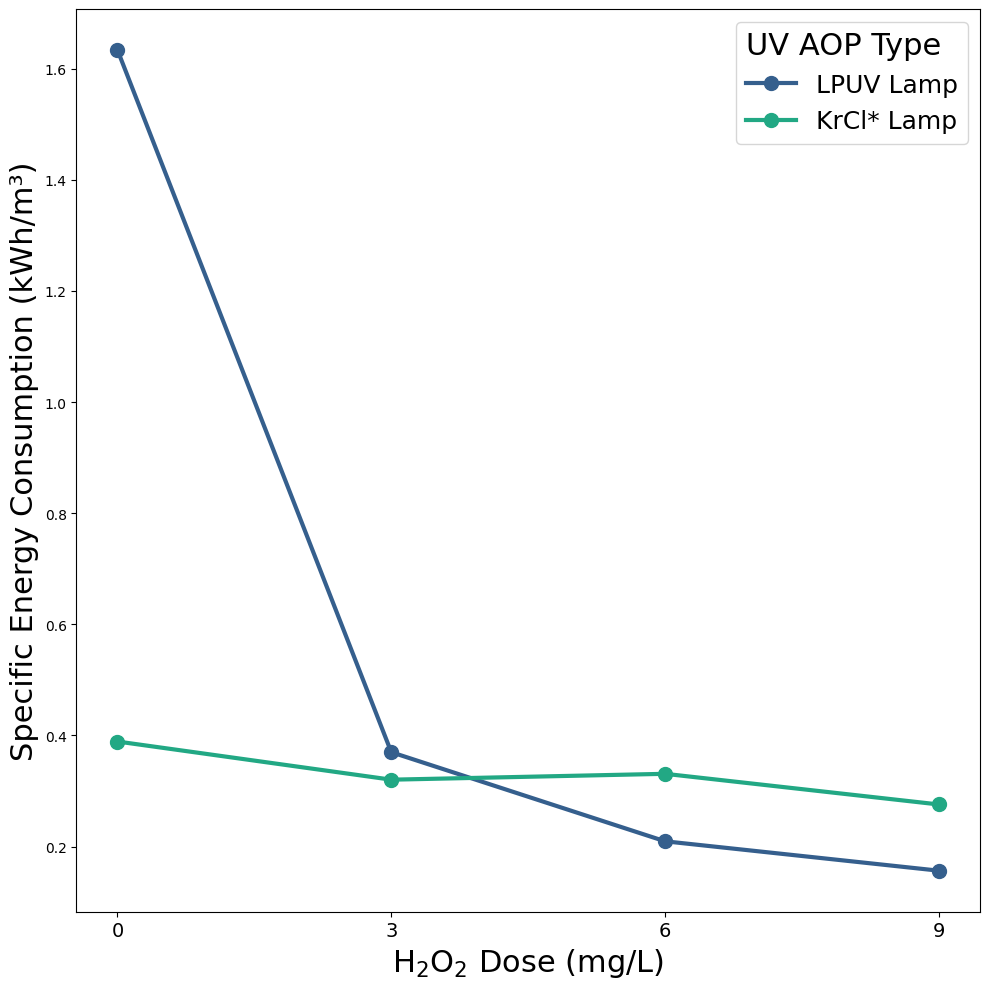

In [24]:
#create plot of specific energy consumption versus H2O2 dose for each lamp type (figure 1a)
fig, ax = plt.subplots(figsize=(10, 10), sharex=True)

#import the viridis colormap
from matplotlib.cm import viridis

#plot line chart of energy consumption versus H2O2 dose for LPUV lamp
subset = base_diox_LCOW[base_diox_LCOW['lamp_type'] == 'LPUV']
ax.plot(subset['H2O2 cnc'], subset['specific_energy_consumption'], marker = 'o', label = 'LPUV Lamp', color = viridis(0.3), linewidth = 3, markersize = 10)

#plot line chart of energy consumption versus H2O2 dose for KrCl* lamp
subset = base_diox_LCOW[base_diox_LCOW['lamp_type'] == 'KrCl*']
ax.plot(subset['H2O2 cnc'], subset['specific_energy_consumption'], marker = 'o', label = 'KrCl* Lamp', color = viridis(0.6), linewidth = 3, markersize = 10)

#format plot
ax.set_ylabel('Specific Energy Consumption (kWh/m³)', fontsize = 22)
ax.set_xlabel('H$_2$O$_2$ Dose (mg/L)', fontsize = 22)
ax.grid(False)
ax.legend(title="UV AOP Type", fontsize = 18, title_fontsize = 22, alignment ='left')
ax.set_xticks([0, 3, 6, 9])
ax.set_xticklabels([0, 3, 6, 9], fontsize =14)
plt.tight_layout()

#export figure
plt.savefig('figure_1a.jpeg', bbox_inches = 'tight')
plt.show()

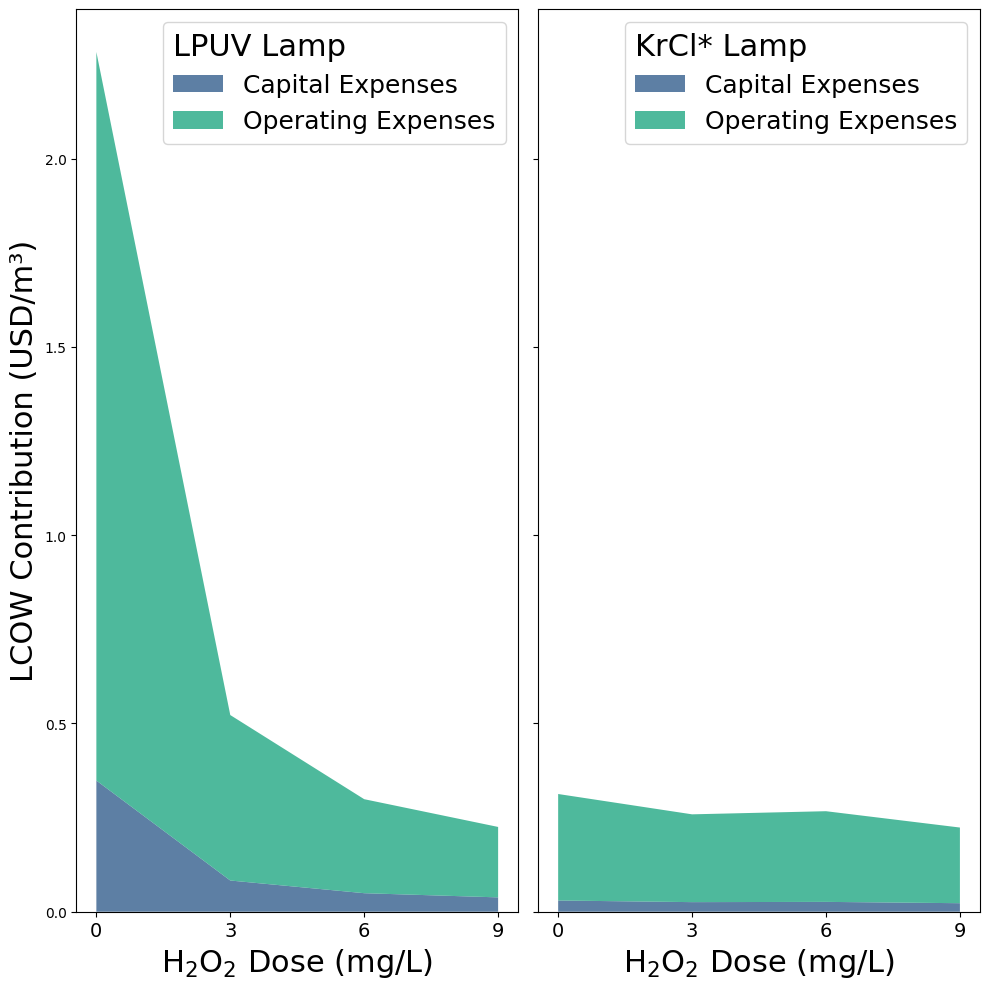

In [25]:
#create plot of capital expenditure (CAPEX) and operating expenditure (OPEX) versus H2O2 dose for each lamp type (figure 1b and c)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10), sharex=True, sharey=True)

#plot stacked area chart of cost for LPUV lamp
subset = base_diox_LCOW[base_diox_LCOW['lamp_type'] == 'LPUV']
h2o2_dose = subset['H2O2 cnc']
capex = subset['LCOW_capex']
opex = subset['LCOW_opex']
ax1.stackplot(h2o2_dose, capex, opex, labels = ['Capital Expenses', 'Operating Expenses'], alpha = 0.8, colors = [viridis(0.3), viridis(0.6)])

#plot stacked area chart of cost for KrCl* lamp
subset = base_diox_LCOW[base_diox_LCOW['lamp_type'] == 'KrCl*']
h2o2_dose = subset['H2O2 cnc']
capex = subset['LCOW_capex']
opex = subset['LCOW_opex']
ax2.stackplot(h2o2_dose, capex, opex, labels = ['Capital Expenses', 'Operating Expenses'], alpha = 0.8, colors = [viridis(0.3), viridis(0.6)])

#format plot
ax1.set_xlabel('H$_2$O$_2$ Dose (mg/L)', fontsize = 22)
ax2.set_xlabel('H$_2$O$_2$ Dose (mg/L)', fontsize = 22)
ax1.set_ylabel('LCOW Contribution (USD/m³)', fontsize = 22)
ax1.grid(False)
ax1.legend(title = "LPUV Lamp", fontsize = 18, title_fontsize = 22, alignment = 'left')
ax2.legend(title = "KrCl* Lamp", fontsize = 18, title_fontsize = 22, alignment = 'left')
ax1.set_xticks([0, 3, 6, 9])
ax1.set_xticklabels([0, 3, 6, 9], fontsize = 14)
ax2.set_xticks([0, 3, 6, 9])
ax2.set_xticklabels([0, 3, 6, 9], fontsize = 14)
plt.tight_layout()

#export figure
plt.savefig('figure_1b_c.jpeg', bbox_inches = 'tight')
plt.show()

In [26]:
#estimate average log removal for each lamp type
print('Average LPUV NDMA log reduction: ' + str(base_ndma_LCOW.loc[base_ndma_LCOW['lamp_type'] == 'LPUV', 'log_removal'].mean()))
print('Average KrCl NDMA log reduction: ' + str(base_ndma_LCOW.loc[base_ndma_LCOW['lamp_type'] == 'KrCl*', 'log_removal'].mean()))

Average LPUV NDMA log reduction: 6.887304868888656
Average KrCl NDMA log reduction: 7.266738634498897


In [34]:
#initialize dataframe to hold UV dose versus log removal of NDMA data for each lamp type
base_ndma_lr = pd.DataFrame(columns=['lamp_type', 'log_removal', 'uv_dose','LCOW', 'specific_energy_consumption','LCOW_capex', 'LCOW_opex'])

#initialize baseline model for NDMA degradation by both lamp types (assuming one lamp can deliver required UV dose)
for lamp_type in ['LPUV', 'KrCl*']:
    #set lower and upper bounds for UV dose [J/m^2]
    lower_bound = 1
    upper_bound = 1000

    #solve baseline model at different UV doses to generate UV dose vs log removal curve
    for dose in range(lower_bound, upper_bound+1, 20):
        m, log_removal, num_reactors = build_model(1, lamp_type, 'NDMA', False, dose_override = dose)
            
        #add UV dose vs log removal data to dataframe for comparing scenarios
        base_ndma_lr.loc[len(base_ndma_lr)] = [
            lamp_type,
            log_removal,
            dose,
            value(m.fs.costing.LCOW),
            value(m.fs.costing.specific_energy_consumption),
            value(m.fs.costing.LCOW_capex),
            value(m.fs.costing.LCOW_opex)
        ]

2025-12-22 10:26:27 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.control_volume.properties_in[0.0].flow_mass_phase_comp[Liq,H2O]
2025-12-22 10:26:27 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.control_volume.properties_in[0.0].flow_mass_phase_comp[Liq,NDMA]
2025-12-22 10:26:27 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.control_volume.properties_out[0.0].flow_mass_phase_comp[Liq,H2O]
2025-12-22 10:26:27 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.control_volume.properties_out[0.0].flow_mass_phase_comp[Liq,NDMA]
2025-12-22 10:26:27 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.uv_intensity
2025-12-22 10:26:27 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.exposure_time
2025-12-22 10:26:27 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.uv_dose
2025-12-22 10:26:27 [WARNING] idaes.core.util.scaling: Missin

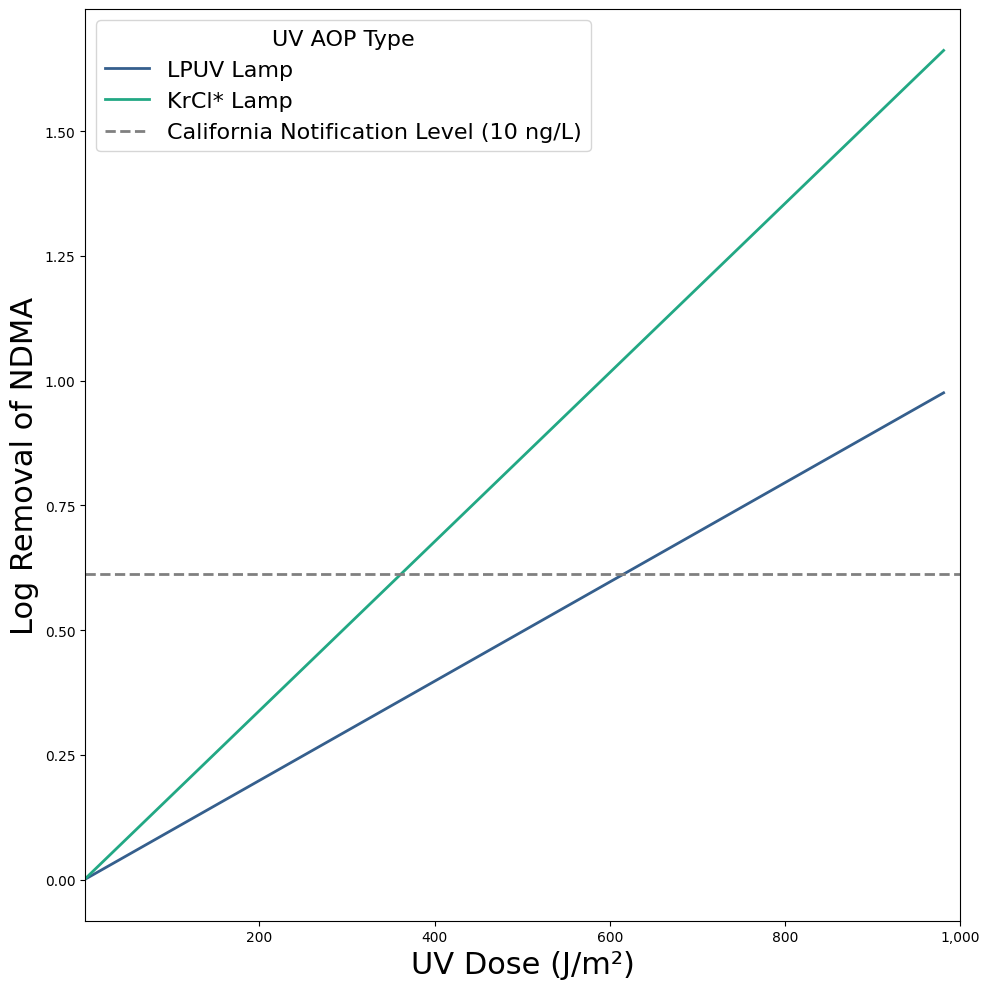

In [39]:
#create plot of UV dose versus NDMA log removal for each lamp type (Figure 2)
fig, ax = plt.subplots(figsize=(10, 10), sharex=True)

#plot line chart of log removal versus UV dose for LPUV lamp
subset = base_ndma_lr[base_ndma_lr['lamp_type'] == 'LPUV']
ax.plot(subset['uv_dose'], subset['log_removal'], label = 'LPUV Lamp', color = viridis(0.3), linewidth = 2)

#plot line chart of log removal versus UV dose for KrCl* lamp
subset = base_ndma_lr[base_ndma_lr['lamp_type'] == 'KrCl*']
ax.plot(subset['uv_dose'], subset['log_removal'], label = 'KrCl* Lamp', color = viridis(0.6), linewidth = 2)

#add horizontal line for 0.613 log removal (reduces NDMA concentration to 10 ng/L, the California notification limit)
ax.plot([lower_bound, upper_bound], [0.613, 0.613], color='gray', linestyle='--', linewidth = 2)

#format plot
def format_with_commas(x, pos):
    return f'{int(x):,}'
ax.xaxis.set_major_formatter(FuncFormatter(format_with_commas))
ax.set_ylabel('Log Removal of NDMA', fontsize = 22)
ax.set_xlabel('UV Dose (J/m²)', fontsize = 22)
ax.grid(False)
ax.legend(title = "UV AOP Type", fontsize = 18, title_fontsize = 22)
ax.set_xlim([lower_bound, 1000])
line = mlines.Line2D([], [], color = 'gray', linestyle='--', linewidth = 2, label = 'California Notification Level (10 ng/L)')
ax.legend(handles=ax.get_legend_handles_labels()[0] + [line], labels=ax.get_legend_handles_labels()[1] + ['California Notification Level (10 ng/L)'], title="UV AOP Type", fontsize=16, title_fontsize=16)

#export figure
plt.tight_layout()
plt.savefig('figure_2.jpeg', bbox_inches='tight')
plt.show()

### Compare LPUV lamps versus a KrCl* lamps for potable reuse of greywater (multiple reactors in series)

In [41]:
#create dataframes to store energy/cost results for each lamp and H2O2 dose (assuming multiple reactors in series are required to deliver UV doses for 0.5 log reduction of 1,4-dioxane)
base_diox_LCOW = pd.DataFrame(columns=['tea_scenario', 'H2O2 cnc', 'lamp_type', 'LCOW', 'specific_energy_consumption', 'LCOW_capex', 'LCOW_opex','num_reactors'])
base_ndma_LCOW = pd.DataFrame(columns=['tea_scenario', 'H2O2 cnc', 'lamp_type', 'LCOW', 'specific_energy_consumption', 'LCOW_capex', 'LCOW_opex', 'log_removal', 'num_reactors'])

#iterate through evaluated contaminants, oxidant doses, and lamp types
for contaminant in ['1,4-dioxane', 'NDMA']:
    for tea_scenario in [1, 2, 3, 4]:
        for lamp_type in ['LPUV', 'KrCl*', 'Alt-LPUV']:
            #set maximum UV dose (based on reactor size and rated power consumption) per reactor for each lamp type
            if lamp_type == 'LPUV':
                max_dose = 230 * (0.0081/flow_rate) / (math.pi * .103) * 0.375 #maximum UV dose per reactor [J/m2] for low-pressure mercury lamps (VIQUA PRO 30))
            elif lamp_type == 'KrCl*':
                max_dose = 500 * (0.0081/flow_rate) / (math.pi * .103) * 0.06 #maximum UV dose per reactor [J/m2] for KrCl* excimer lamps (First UVC's KrCl* lamp)
            else:
                max_dose =  4600 * (0.085/flow_rate) / (math.pi * .3 * 1.2) * 0.35 #maximum UV dose per reactor [J/m2] for alternative low-pressure mercury lamps (TrojanUVPhox))    
            if contaminant == '1,4-dioxane':
                #solve baseline model
                m, log_removal, num_reactors = build_model(tea_scenario, lamp_type, contaminant, True, dose_override = max_dose)
                #append modeling results to dataframe for comparing scenarios
                match tea_scenario:
                    case 1:
                        h202 = 0
                    case 2:
                        h202 = 3
                    case 3:
                        h202 = 6
                    case 4:
                        h202 = 9

                base_diox_LCOW.loc[len(base_diox_LCOW)] = [
                    tea_scenario,
                    h202,
                    lamp_type,
                    value(m.fs.costing.LCOW),
                    value(m.fs.costing.specific_energy_consumption),
                    value(m.fs.costing.LCOW_capex),
                    value(m.fs.costing.LCOW_opex),
                    num_reactors
                ]
            elif contaminant == 'NDMA':
                #solve baseline model
                m, log_removal, num_reactors = build_model(tea_scenario, lamp_type, contaminant, True, dose_override = max_dose)
                #add LCOW to dataframe for comparing scenarios
                match tea_scenario:
                    case 1:
                        h202 = 0
                    case 2:
                        h202 = 3
                    case 3:
                        h202 = 6
                    case 4:
                        h202 = 9

                #append modeling results to dataframe for comparing scenarios
                base_ndma_LCOW.loc[len(base_ndma_LCOW)] = [
                    tea_scenario,
                    h202,
                    lamp_type,
                    value(m.fs.costing.LCOW),
                    value(m.fs.costing.specific_energy_consumption),
                    value(m.fs.costing.LCOW_capex),
                    value(m.fs.costing.LCOW_opex),
                    log_removal,
                    num_reactors
                ]    

2025-12-22 10:57:32 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.control_volume.properties_in[0.0].flow_mass_phase_comp[Liq,H2O]
2025-12-22 10:57:32 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.control_volume.properties_in[0.0].flow_mass_phase_comp[Liq,Dioxane]
2025-12-22 10:57:32 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.control_volume.properties_out[0.0].flow_mass_phase_comp[Liq,H2O]
2025-12-22 10:57:32 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.control_volume.properties_out[0.0].flow_mass_phase_comp[Liq,Dioxane]
2025-12-22 10:57:32 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.uv_intensity
2025-12-22 10:57:32 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.exposure_time
2025-12-22 10:57:32 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.uv_dose
2025-12-22 10:57:32 [WARNING] idaes.core.util.scaling: 

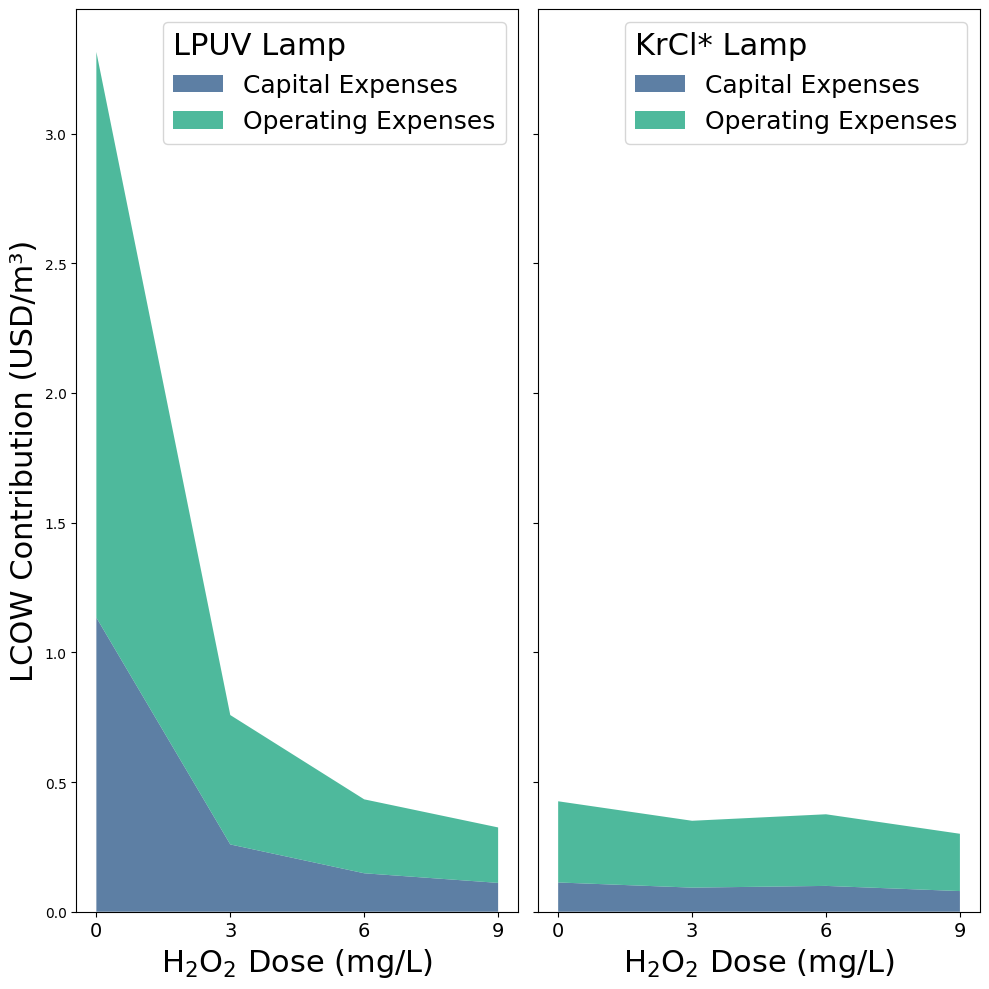

In [42]:
#create plot of CAPEX and OPEX versus H2O2 dose for each lamp type, assuming multiple reactors in series are required to deliver UV doses for 0.5 log reduction of 1,4-dioxane (figure 3)
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 10), sharex = True, sharey = True)

#plot stacked area chart of cost for LPUV lamp
subset = base_diox_LCOW[base_diox_LCOW['lamp_type'] == 'LPUV']
h2o2_dose = subset['H2O2 cnc']
capex = subset['LCOW_capex']
opex = subset['LCOW_opex']
ax1.stackplot(h2o2_dose, capex, opex, labels = ['Capital Expenses', 'Operating Expenses'], alpha = 0.8, colors = [viridis(0.3), viridis(0.6)])

#plot stacked area chart of cost for KrCl* lamp
subset = base_diox_LCOW[base_diox_LCOW['lamp_type'] == 'KrCl*']
h2o2_dose = subset['H2O2 cnc']
capex = subset['LCOW_capex']
opex = subset['LCOW_opex']
ax2.stackplot(h2o2_dose, capex, opex, labels = ['Capital Expenses', 'Operating Expenses'], alpha = 0.8, colors = [viridis(0.3), viridis(0.6)])

#format plot
ax1.set_xlabel('H$_2$O$_2$ Dose (mg/L)', fontsize = 22)
ax2.set_xlabel('H$_2$O$_2$ Dose (mg/L)', fontsize = 22)
ax1.set_ylabel('LCOW Contribution (USD/m³)', fontsize = 22)
ax1.grid(False)
ax1.legend(title="LPUV Lamp", fontsize = 18, title_fontsize = 22, alignment = 'left')
ax2.legend(title="KrCl* Lamp", fontsize = 18, title_fontsize = 22, alignment = 'left')
ax1.set_xticks([0, 3, 6, 9])
ax1.set_xticklabels([0, 3, 6, 9], fontsize = 14)
ax2.set_xticks([0, 3, 6, 9])
ax2.set_xticklabels([0, 3, 6, 9], fontsize = 14)
plt.tight_layout()

#export figure
plt.savefig('figure_3.jpeg', bbox_inches = 'tight')
plt.show()

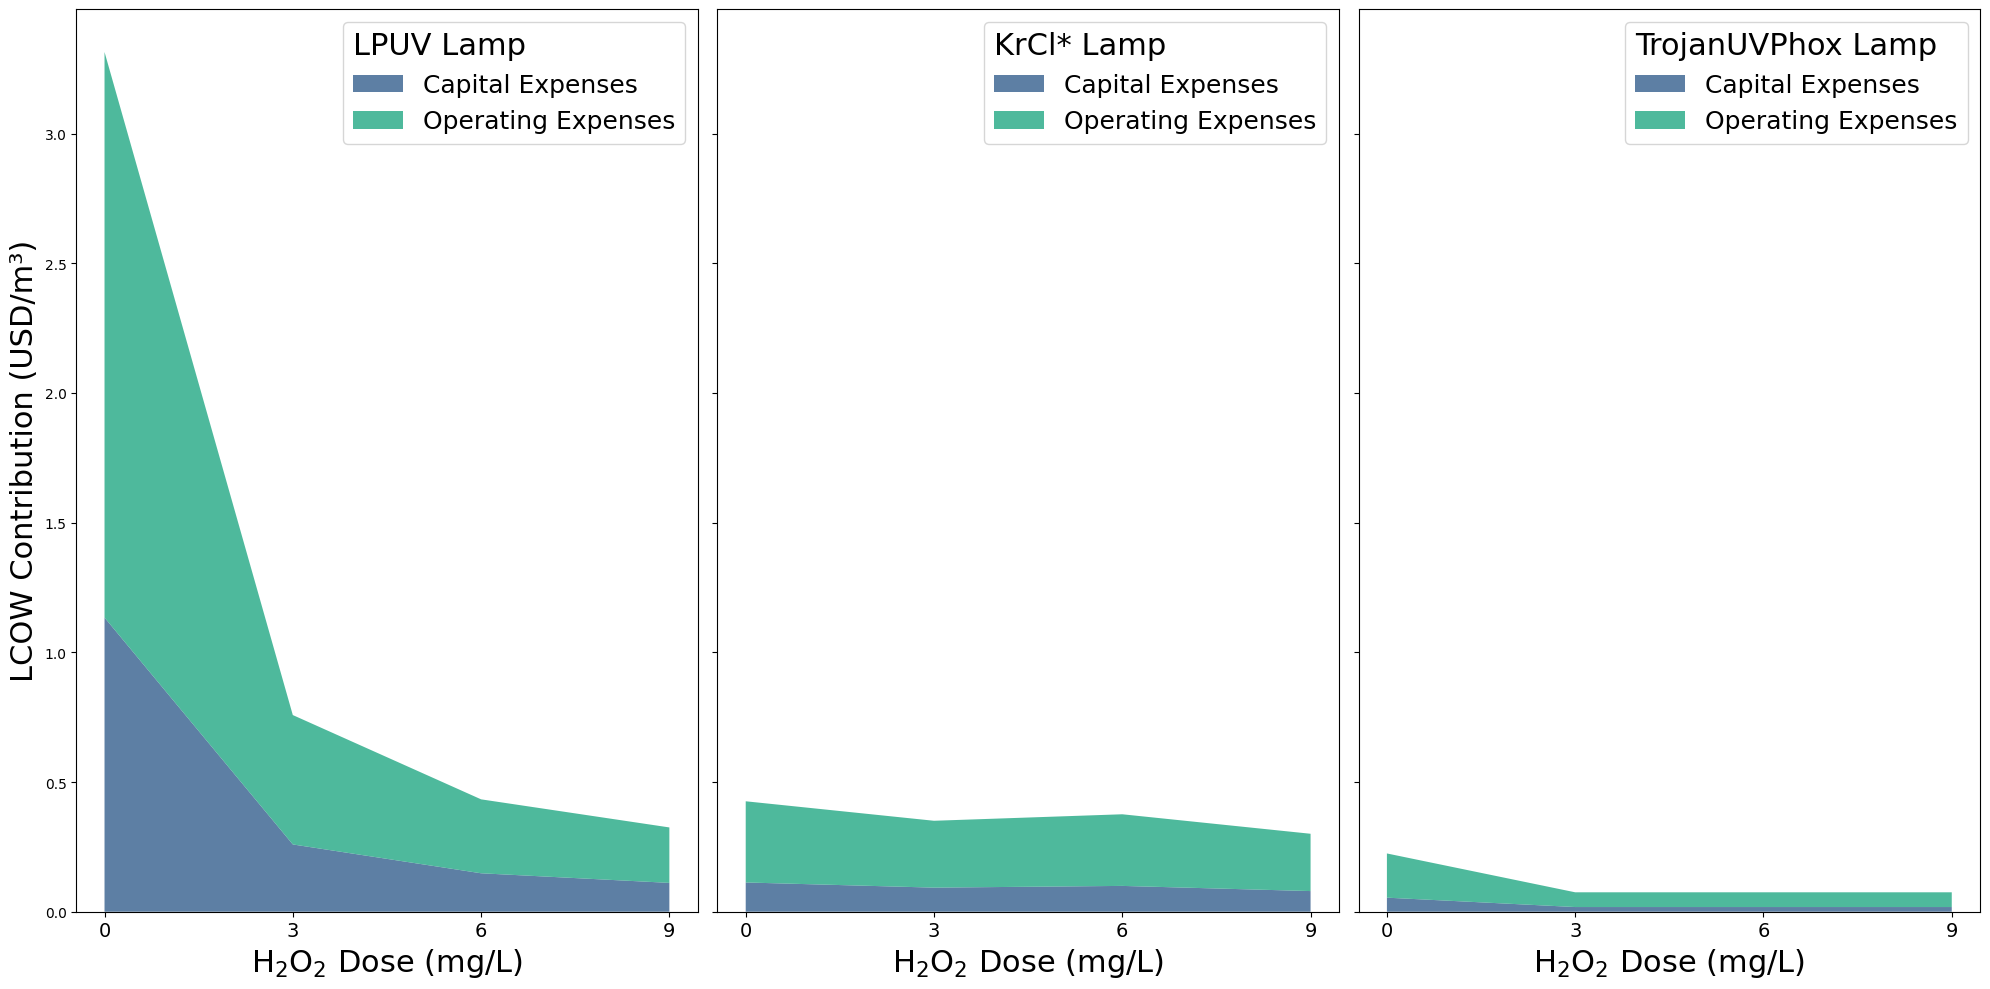

In [43]:
#create plot of CAPEX and OPEX versus H2O2 for each lamp type, including alternative LPUV, assuming multiple reactors in series are required to deliver UV doses for 0.5 log reduction of 1,4-dioxane (figure 4)
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 10), sharex=True, sharey=True)

#plot stacked area chart of cost for LPUV lamp
subset = base_diox_LCOW[base_diox_LCOW['lamp_type'] == 'LPUV']
h2o2_dose = subset['H2O2 cnc']
capex = subset['LCOW_capex']
opex = subset['LCOW_opex']
ax1.stackplot(h2o2_dose, capex, opex, labels=['Capital Expenses', 'Operating Expenses'], alpha = 0.8, colors = [viridis(0.3), viridis(0.6)])

#plot stacked area chart of cost for KrCl* lamp
subset = base_diox_LCOW[base_diox_LCOW['lamp_type'] == 'KrCl*']
h2o2_dose = subset['H2O2 cnc']
capex = subset['LCOW_capex']
opex = subset['LCOW_opex']
ax2.stackplot(h2o2_dose, capex, opex, labels=['Capital Expenses', 'Operating Expenses'], alpha = 0.8, colors = [viridis(0.3), viridis(0.6)])

#plot stacked area chart of cost for TrojanUVPhox lamp
subset = base_diox_LCOW[base_diox_LCOW['lamp_type'] == 'Alt-LPUV']
h2o2_dose = subset['H2O2 cnc']
capex = subset['LCOW_capex']
opex = subset['LCOW_opex']
ax3.stackplot(h2o2_dose, capex, opex, labels=['Capital Expenses', 'Operating Expenses'], alpha = 0.8, colors = [viridis(0.3), viridis(0.6)])

#format plot
ax1.set_xlabel('H$_2$O$_2$ Dose (mg/L)', fontsize = 22)
ax2.set_xlabel('H$_2$O$_2$ Dose (mg/L)', fontsize = 22)
ax3.set_xlabel('H$_2$O$_2$ Dose (mg/L)', fontsize = 22)
ax1.set_ylabel('LCOW Contribution (USD/m³)', fontsize = 22)
ax1.grid(False)
ax1.legend(title="LPUV Lamp", fontsize = 18, title_fontsize = 22, alignment = 'left')
ax2.legend(title="KrCl* Lamp", fontsize = 18, title_fontsize = 22, alignment = 'left')
ax3.legend(title="TrojanUVPhox Lamp", fontsize = 18, title_fontsize = 22, alignment = 'left')
ax1.set_xticks([0, 3, 6, 9])
ax1.set_xticklabels([0, 3, 6, 9], fontsize = 14)
ax2.set_xticks([0, 3, 6, 9])
ax2.set_xticklabels([0, 3, 6, 9], fontsize = 14)
ax3.set_xticks([0, 3, 6, 9])
ax3.set_xticklabels([0, 3, 6, 9], fontsize = 14)
plt.tight_layout()

#export figure
plt.savefig('figure_4.jpeg', bbox_inches = 'tight')
plt.show()

### Analyze sensitivity of UV AOP performance to flow rate and lamp replacement factor

In [13]:
#define functions to assess sensitivity of LCOW and specific energy consumption to flow rate
def build_sweep_params(model, **kwargs):
    """Define parameters to vary and their ranges"""
    sweep_params = dict()
    sweep_params['Flow Rate'] = LinearSample(model.fs.unit_1.inlet.flow_mass_phase_comp[0, 'Liq', 'H2O'], 1.89, 6.31, 10) #30-100 gpm in kg/s
    return sweep_params

def build_outputs(model, **kwargs):
    """Define outputs to track"""
    outputs = dict()
    outputs['LCOW'] = model.fs.costing.LCOW
    outputs['Specific Energy Consumption'] = model.fs.costing.specific_energy_consumption
    return outputs

#run the parameter sweep across evaluated flow rates, lamp types, and H2O2 doses 
for tea_scenario in [1, 2, 3, 4]:
    for lamp_type in ['LPUV', 'KrCl*']:
        try:
            #build the model once per iteration
            model, _, _ = build_model(tea_scenario, lamp_type, '1,4-dioxane', True)
            
            #define sweep parameters and outputs
            sweep_params = build_sweep_params(model)
            outputs = build_outputs(model)
            
            #run the parameter sweep and export results to CSV
            parameter_sweep(
                model,
                sweep_params,
                outputs,
                csv_results_file_name=f'sensitivity_results_TEA_{tea_scenario}_{lamp_type}.csv',
            )
            print(f"Parameter sweep completed successfully for TEA scenario {tea_scenario} and lamp type {lamp_type}.")
        except Exception as e:
            print(f"Error during parameter sweep for TEA scenario {tea_scenario} and lamp type {lamp_type}: {e}")

2025-12-22 09:58:42 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.control_volume.properties_in[0.0].flow_mass_phase_comp[Liq,H2O]
2025-12-22 09:58:42 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.control_volume.properties_in[0.0].flow_mass_phase_comp[Liq,Dioxane]
2025-12-22 09:58:42 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.control_volume.properties_out[0.0].flow_mass_phase_comp[Liq,H2O]
2025-12-22 09:58:42 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.control_volume.properties_out[0.0].flow_mass_phase_comp[Liq,Dioxane]
2025-12-22 09:58:42 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.uv_intensity
2025-12-22 09:58:42 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.exposure_time
2025-12-22 09:58:42 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.uv_dose
2025-12-22 09:58:42 [WARNING] idaes.core.util.scaling: 

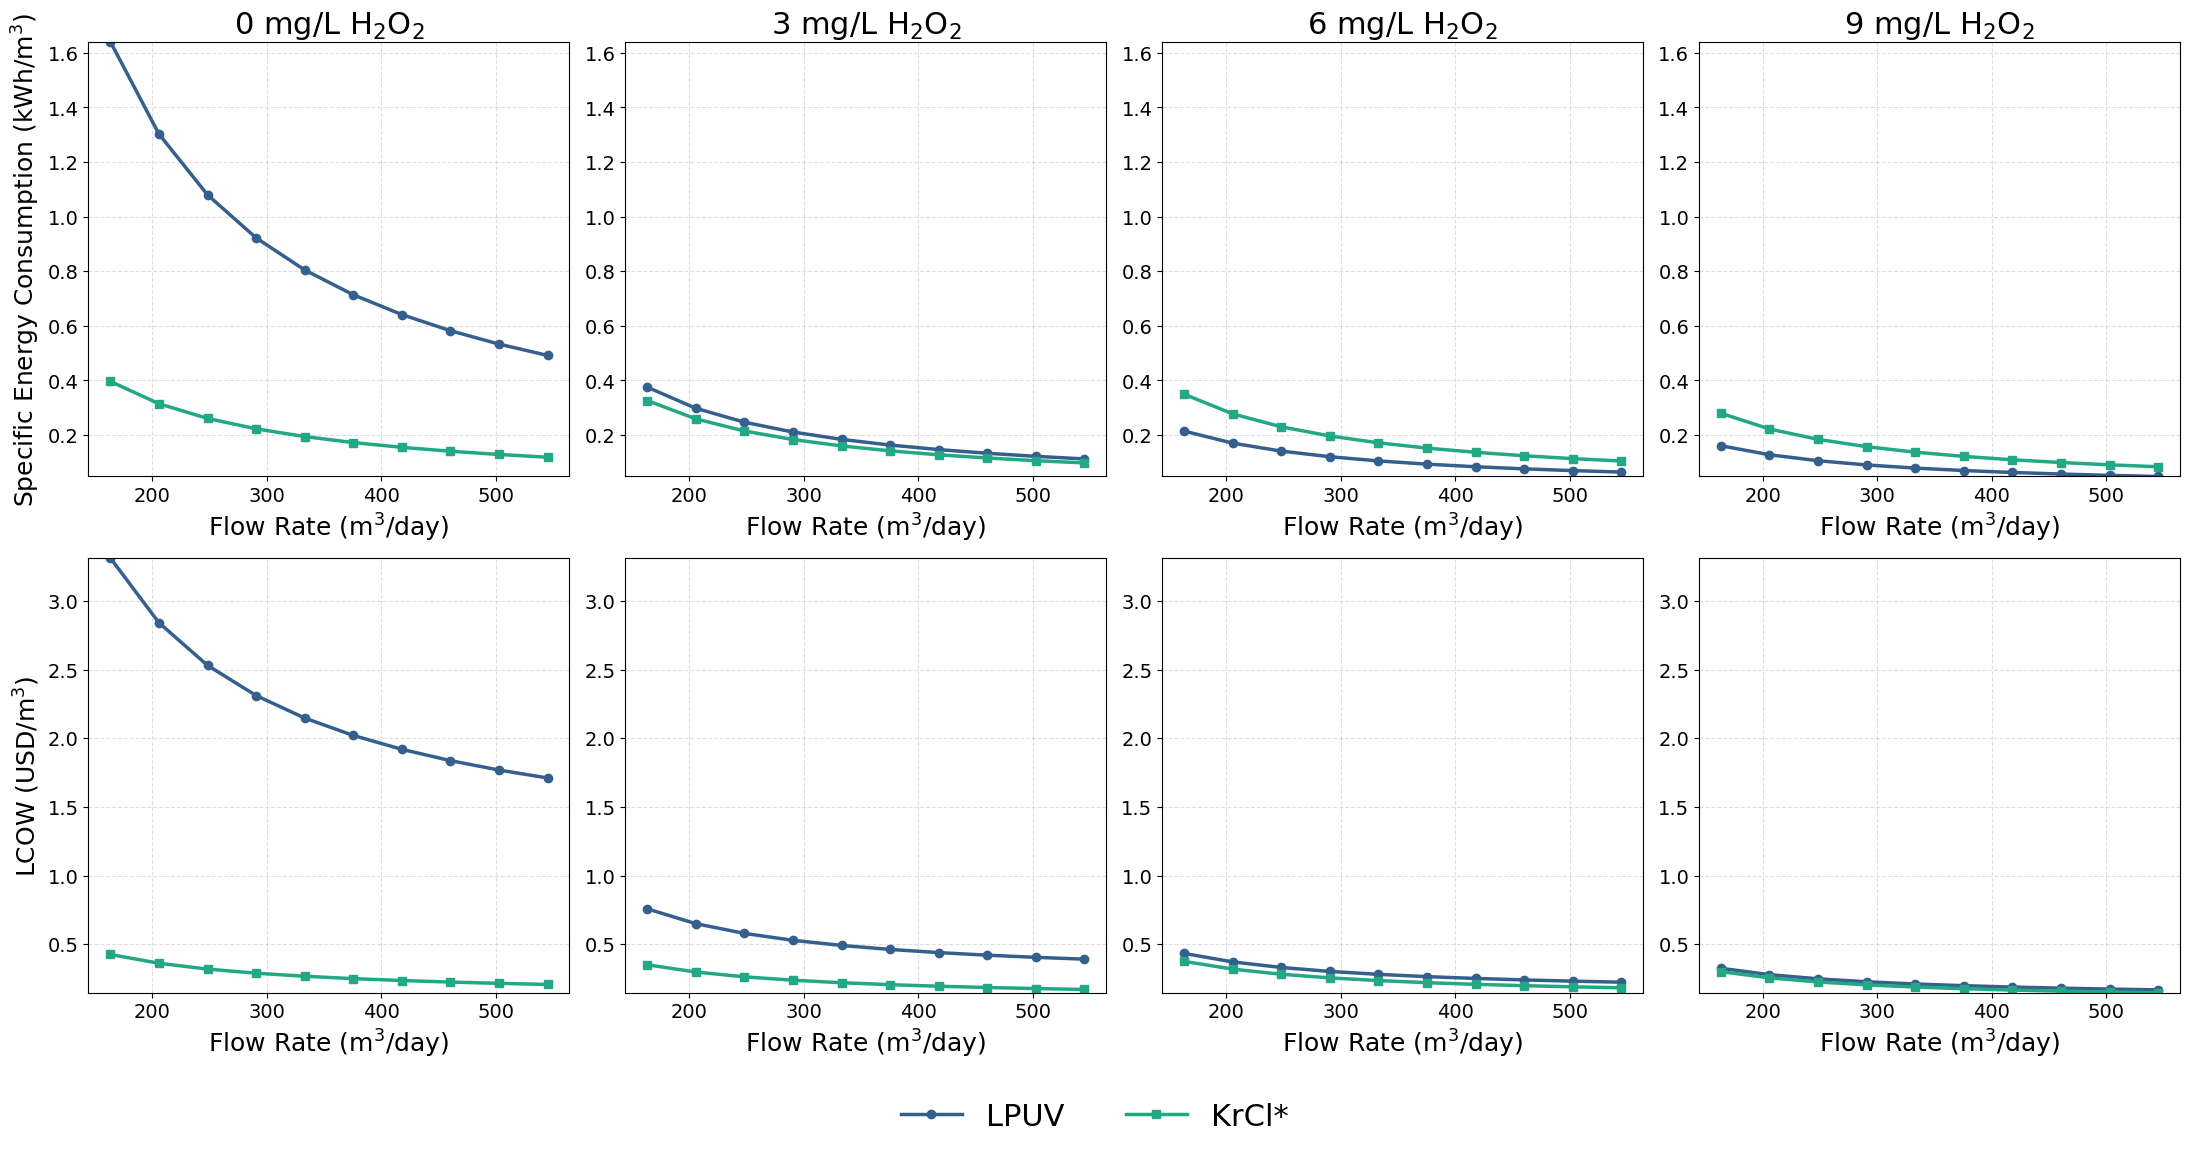

In [14]:
#create line plots of specific energy consumption and LCOW vs flow rate for each lamp type and H2O2 dose (figure 5)
fig, axes = plt.subplots(2, 4, figsize = (22, 12), sharey = False)
markers = {"LPUV": "o", "KrCl*": "s"}
colors  = {"LPUV": viridis(0.3), "KrCl*": viridis(0.6)}

titles = {
    1: "0 mg/L H$_2$O$_2$",
    2: "3 mg/L H$_2$O$_2$",
    3: "6 mg/L H$_2$O$_2$",
    4: "9 mg/L H$_2$O$_2$",
}

#reformat parameter sweep results for plotting
SEC_data  = {"LPUV": {}, "KrCl*": {}}
LCOW_data = {"LPUV": {}, "KrCl*": {}}
for lamp_type in ['LPUV', 'KrCl*']:
    for i in [1, 2, 3, 4]:
        #load in parameter sweep data
        df = pd.read_csv(f"sensitivity_results_TEA_{i}_{lamp_type}.csv")

        # convert flow rate to m3/day
        df['# Flow Rate'] = df['# Flow Rate'] * 86.4

        SEC_data[lamp_type][i]  = df[['# Flow Rate', 'Specific Energy Consumption']]
        LCOW_data[lamp_type][i] = df[['# Flow Rate', 'LCOW']]

#compute shared y-axis limits for specific energy consumption and LCOW
SEC_min = min(SEC_data[lamp][i]['Specific Energy Consumption'].min()
              for lamp in ['LPUV','KrCl*'] for i in [1, 2, 3, 4])
SEC_max = max(SEC_data[lamp][i]['Specific Energy Consumption'].max()
              for lamp in ['LPUV','KrCl*'] for i in [1, 2, 3, 4])
LCOW_min = min(LCOW_data[lamp][i]['LCOW'].min()
               for lamp in ['LPUV','KrCl*'] for i in [1,2 ,3 ,4])
LCOW_max = max(LCOW_data[lamp][i]['LCOW'].max()
               for lamp in ['LPUV','KrCl*'] for i in [1, 2, 3,4])

#iterate through H2O2 doses and plot specific energy consumption versus flow rate
for idx, TEA in enumerate([1, 2, 3, 4]):
    ax = axes[0, idx]

    for lamp_type in ['LPUV', 'KrCl*']:
        df = SEC_data[lamp_type][TEA]
        ax.plot(
            df['# Flow Rate'],
            df['Specific Energy Consumption'],
            marker = markers[lamp_type],
            color = colors[lamp_type],
            linewidth = 2.5,
            label = lamp_type
        )

    ax.set_title(f"{titles[TEA]}", fontsize=22)
    ax.set_xlabel(r"Flow Rate (m$^3$/day)", fontsize=18)
    ax.set_ylim(SEC_min, SEC_max)
    ax.grid(True, linestyle = "--", alpha = 0.4)
    ax.tick_params(axis = "both", labelsize = 14)

axes[0, 0].set_ylabel(r"Specific Energy Consumption (kWh/m$^3$)", fontsize = 18)

#iterate through H2O2 doses and plot LCOW versus flow rate
for idx, TEA in enumerate([1, 2, 3, 4]):
    ax = axes[1, idx]

    for lamp_type in ['LPUV', 'KrCl*']:
        df = LCOW_data[lamp_type][TEA]
        ax.plot(
            df['# Flow Rate'],
            df['LCOW'],
            marker = markers[lamp_type],
            color = colors[lamp_type],
            linewidth = 2.5
        )

    ax.set_xlabel(r"Flow Rate (m$^3$/day)", fontsize = 18)
    ax.set_ylim(LCOW_min, LCOW_max)
    ax.grid(True, linestyle = "--", alpha=0.4)
    ax.tick_params(axis = "both", labelsize = 14)

axes[1, 0].set_ylabel(r"LCOW (USD/m$^3$)", fontsize = 18)

fig.legend(
    ["LPUV", "KrCl*"],
    loc="lower center",
    ncol = 2,
    fontsize = 22,
    frameon = False,
    bbox_to_anchor = (0.5, -0.02)
)

fig.tight_layout(rect=[0, 0.05, 1, 0.95])

#export figure
plt.savefig("figure_5a_b.jpeg", dpi=300, bbox_inches="tight")
plt.show()

In [15]:
#define functions to assess sensitivity of LCOW and specific energy consumption to lamp replacement factor
def build_sweep_params(model, **kwargs):
    """Define parameters to vary and their ranges"""
    sweep_params = dict()
    sweep_params['Flow Rate'] = LinearSample(model.fs.unit_1.inlet.flow_mass_phase_comp[0, 'Liq', 'H2O'], 1.89, 6.31, 10) #30-100 gpm in kg/s
    sweep_params['Lamp Replacement Factor'] = LinearSample(model.fs.costing.ultraviolet.factor_lamp_replacement, 0.5, 2, 10) #replace twice a year to once every two years
    return sweep_params

def build_outputs(model, **kwargs):
    """Define outputs to track"""
    outputs = dict()
    outputs['LCOW'] = model.fs.costing.LCOW
    outputs['Specific Energy Consumption'] = model.fs.costing.specific_energy_consumption
    return outputs

#run the parameter sweep across evaluated lamp replacement factors, lamp types, and H2O2 doses 
for tea_scenario in [1, 2, 3, 4]:
    for lamp_type in ['LPUV', 'KrCl*']:
        try:
            #build the model once per iteration
            model, _, _ = build_model(tea_scenario, lamp_type, '1,4-dioxane', True)
            
            #define sweep parameters and outputs
            sweep_params = build_sweep_params(model)
            outputs = build_outputs(model)
            
            #run the parameter sweep
            parameter_sweep(
                model,
                sweep_params,
                outputs,
                csv_results_file_name=f'sensitivity_results_TEA_{tea_scenario}_{lamp_type}.csv',
            )
            print(f"Parameter sweep completed successfully for TEA scenario {tea_scenario} and lamp type {lamp_type}.")
        except Exception as e:
            print(f"Error during parameter sweep for TEA scenario {tea_scenario} and lamp type {lamp_type}: {e}")

2025-12-22 09:59:27 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.control_volume.properties_in[0.0].flow_mass_phase_comp[Liq,H2O]
2025-12-22 09:59:27 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.control_volume.properties_in[0.0].flow_mass_phase_comp[Liq,Dioxane]
2025-12-22 09:59:27 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.control_volume.properties_out[0.0].flow_mass_phase_comp[Liq,H2O]
2025-12-22 09:59:27 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.control_volume.properties_out[0.0].flow_mass_phase_comp[Liq,Dioxane]
2025-12-22 09:59:27 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.uv_intensity
2025-12-22 09:59:27 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.exposure_time
2025-12-22 09:59:27 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.uv_dose
2025-12-22 09:59:27 [WARNING] idaes.core.util.scaling: 

/var/folders/y1/85r4w0515p15jzrs10_jj1980000gp/T/ipykernel_8860/522962178.py:196: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/y1/85r4w0515p15jzrs10_jj1980000gp/T/ipykernel_8860/522962178.py:196: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


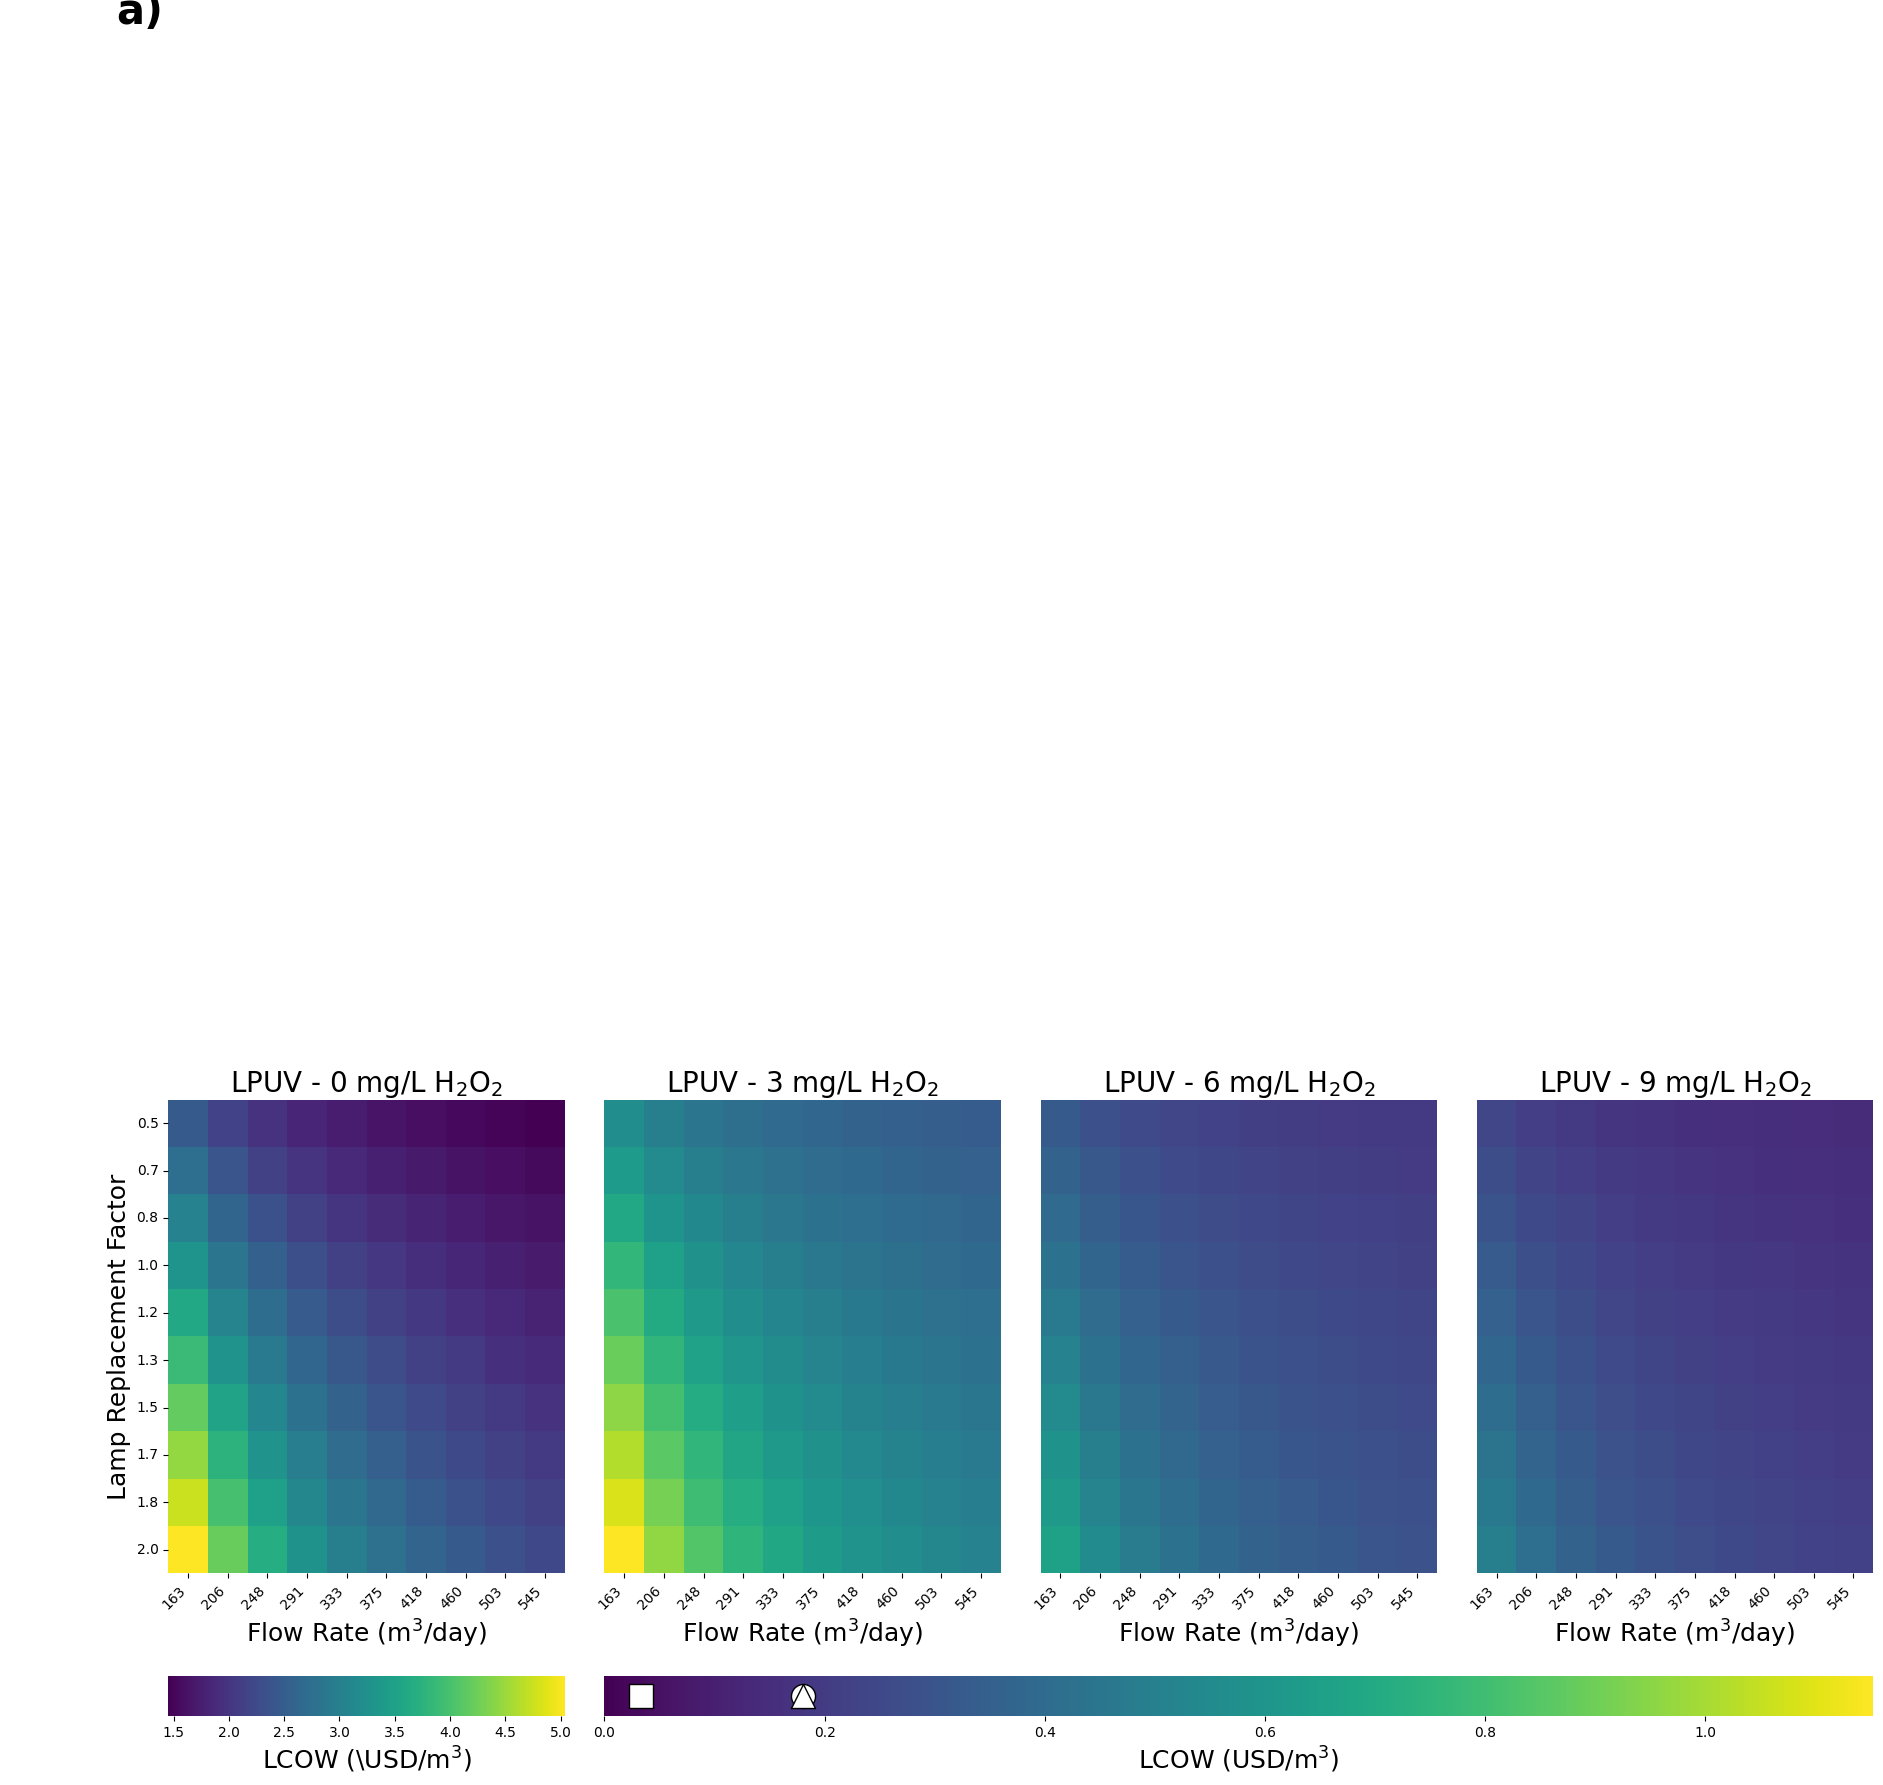

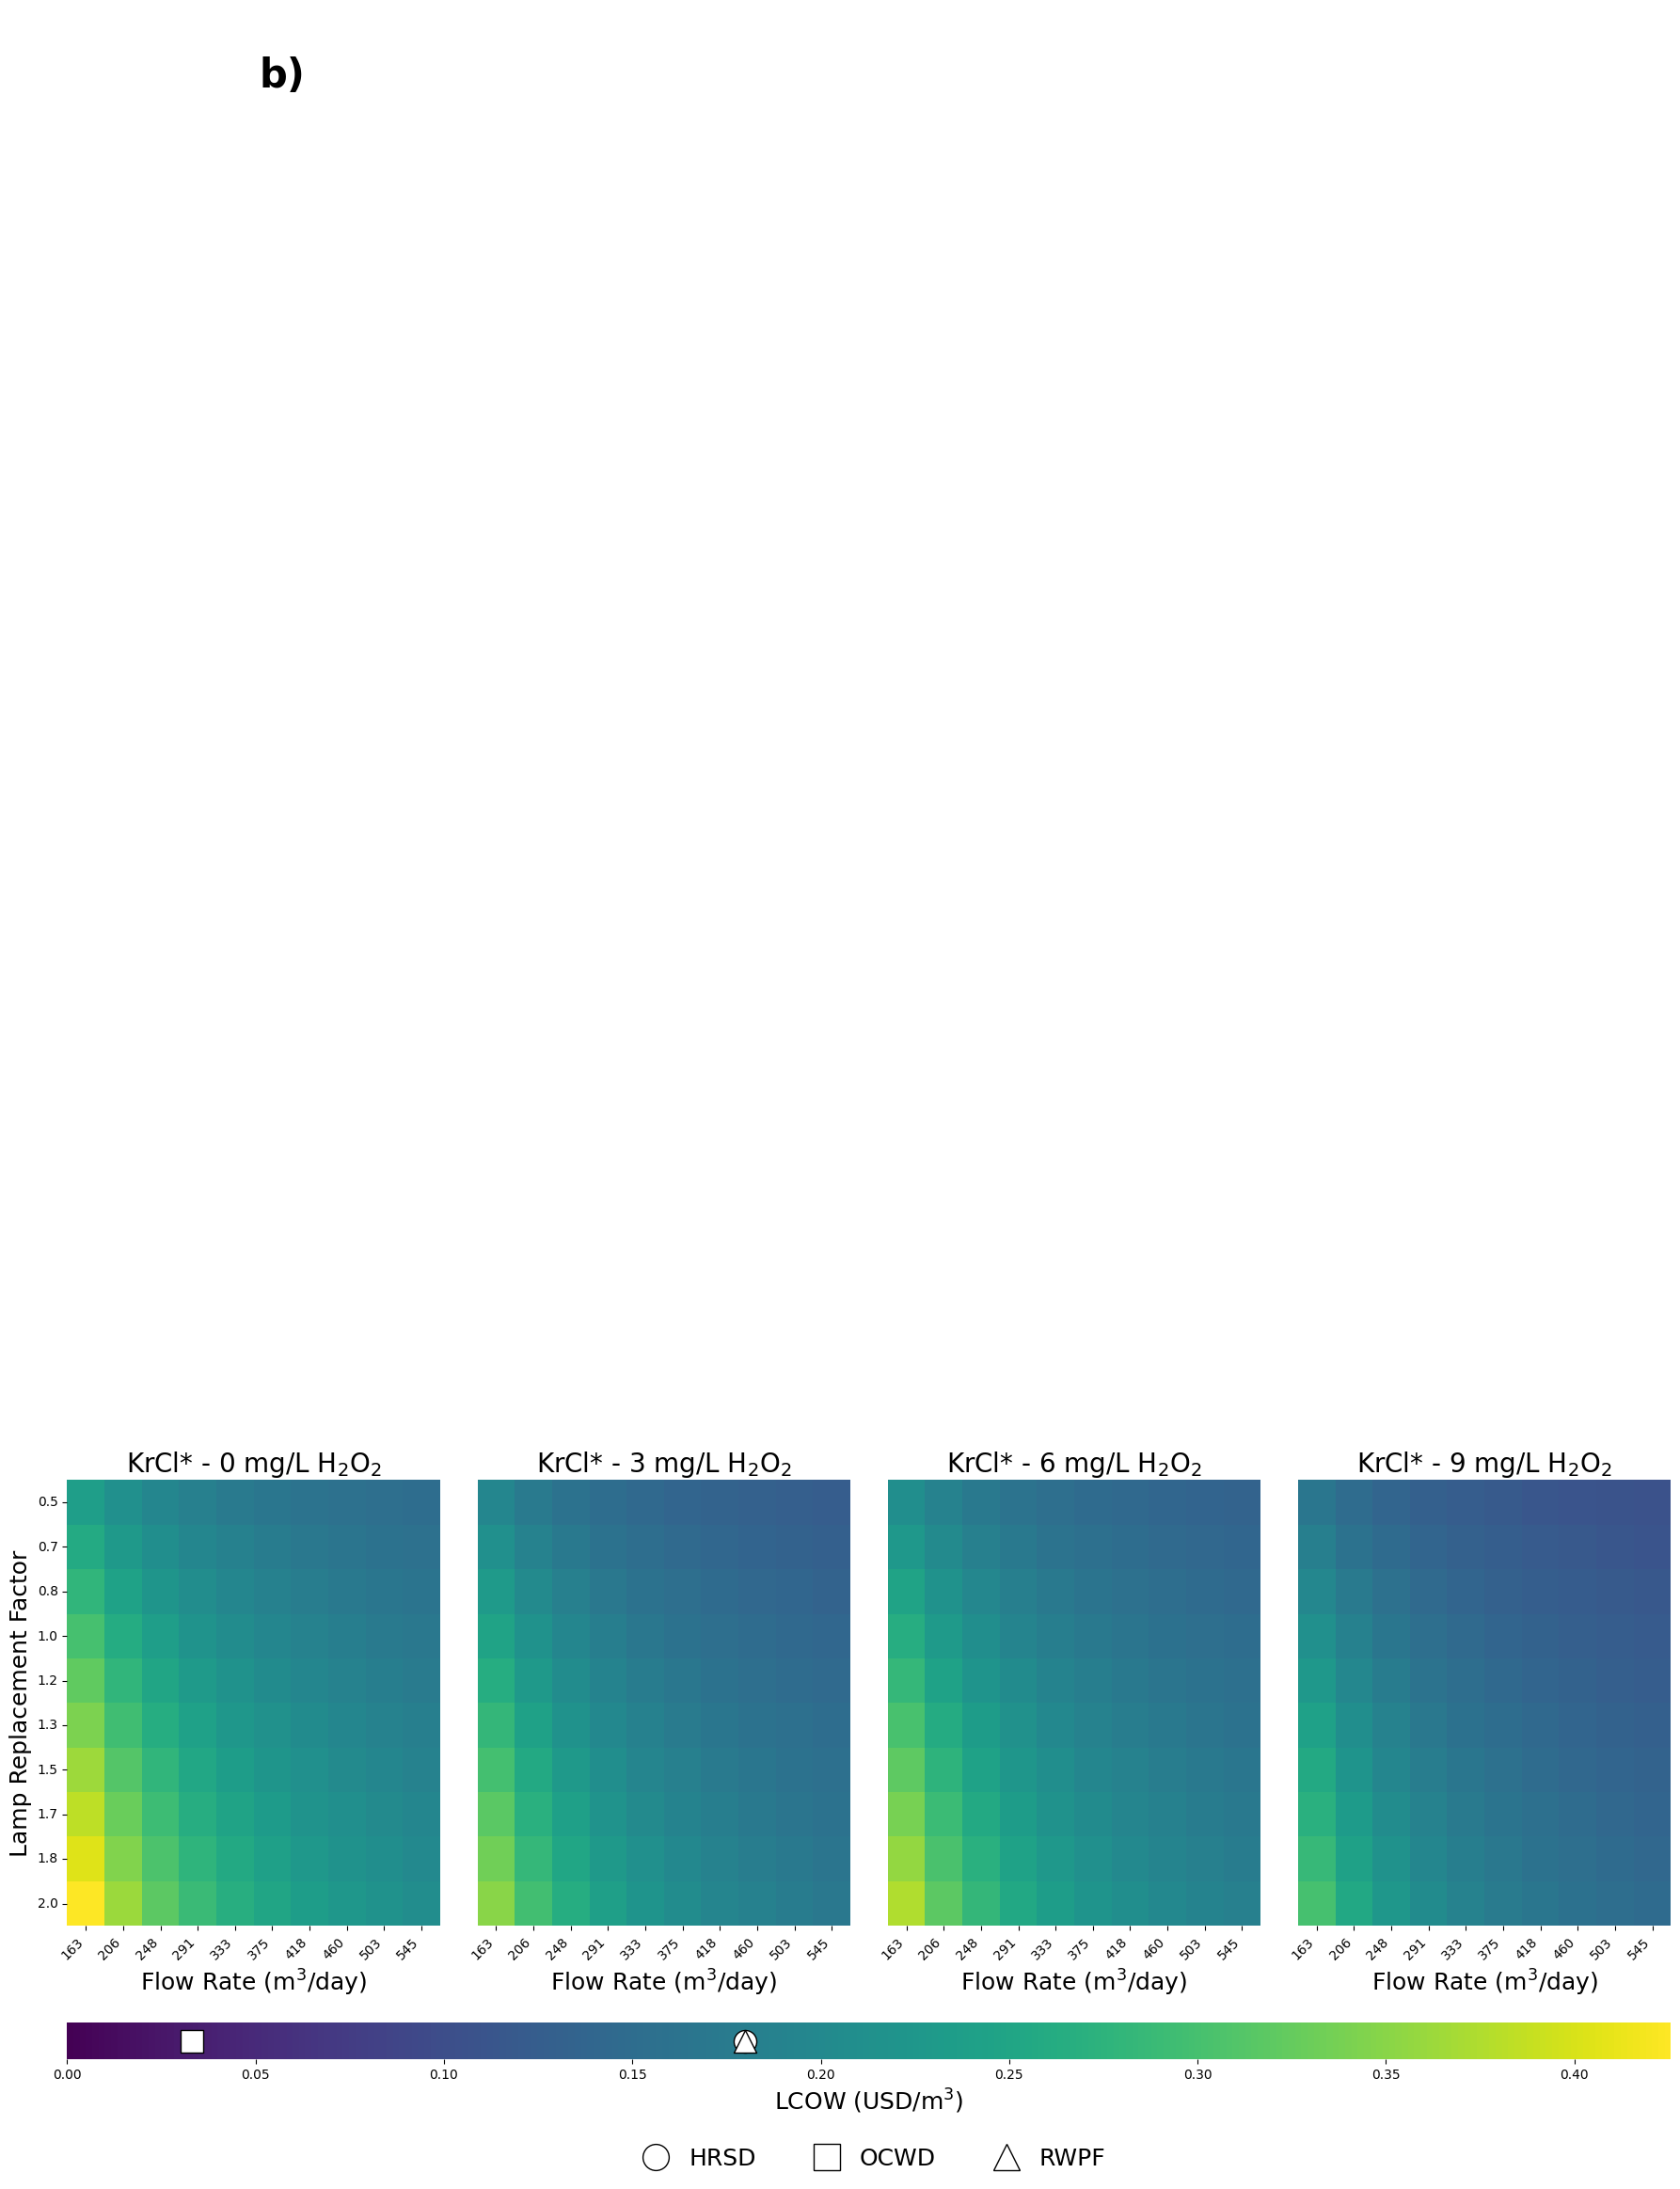

In [16]:
#create heatmaps of sensitivity of LCOW to lamp replacement factor and flow rate (figures 6a and b)
def add_colorbar_markers(cbar_ax):
    """Define function that overlays markers on colorbar for reference LCOWs"""
    #LCOW values to mark
    values = [0.18, 0.033, 0.18]
    markers = ['o', 's', '^']
    sizes = [300, 300, 300]

    for v, m, s in zip(values, markers, sizes):
        cbar_ax.scatter(
            [v], [0.5],                
            marker=m,
            s=s,
            color='white',
            edgecolor='black',
            zorder=5,
            clip_on=False
        )

#iterate through lamp types
for lamp_type in ['LPUV', 'KrCl*']:

    #read in parameter sweep results
    df1 = pd.read_csv(f'sensitivity_results_TEA_1_{lamp_type}.csv')
    df2 = pd.read_csv(f'sensitivity_results_TEA_2_{lamp_type}.csv')
    df3 = pd.read_csv(f'sensitivity_results_TEA_3_{lamp_type}.csv')
    df4 = pd.read_csv(f'sensitivity_results_TEA_4_{lamp_type}.csv')

    #convert flow rate to m3/day
    for df in [df1, df2, df3, df4]:
        df['# Flow Rate'] = df['# Flow Rate'] * 86.4

    #pivot data
    heatmap_data_1 = df1.pivot(index='Lamp Replacement Factor', columns='# Flow Rate', values='LCOW')
    heatmap_data_2 = df2.pivot(index='Lamp Replacement Factor', columns='# Flow Rate', values='LCOW')
    heatmap_data_3 = df3.pivot(index='Lamp Replacement Factor', columns='# Flow Rate', values='LCOW')
    heatmap_data_4 = df4.pivot(index='Lamp Replacement Factor', columns='# Flow Rate', values='LCOW')

    #determine vmin/vmax for TEA scenarios 2–4 for shared scale
    all_234 = np.concatenate([df2['LCOW'], df3['LCOW'], df4['LCOW']])
    vmin_234, vmax_234 = np.nanmin(all_234), np.nanmax(all_234)
    
    #determine vmin/vmax for TEA scenarios 1–4 for shared scale
    all_1234 = np.concatenate([df1['LCOW'], df2['LCOW'], df3['LCOW'], df4['LCOW']])
    vmin_1234, vmax_1234 = np.nanmin(all_1234), np.nanmax(all_1234)

    #set up figure with gridspec
    fig = plt.figure(figsize=(22, 8))
    gs = fig.add_gridspec(
        2, 4,
        height_ratios=[12, 1],
        hspace=0.4,
        wspace=0.1
    )

    #heatmap axes (top row)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[0, 3])

    #plot LPUV lamp heatmaps
    if lamp_type == 'LPUV':
        #add colorbar axes (bottom row)
        cbar1_ax = fig.add_subplot(gs[1, 0]) #under TEA 1
        cbar234_ax = fig.add_subplot(gs[1, 1:4]) #one big bar under TEA 2–4

        #TEA 1 (own colorbar + scale)
        hm1 = sns.heatmap(
            heatmap_data_1,
            ax=ax1,
            cmap="viridis",
            cbar=True,
            vmin = df1['LCOW'].min(),
            vmax = df1['LCOW'].max(),
            cbar_ax=cbar1_ax,
            cbar_kws={"orientation": "horizontal"}
        )
        cbar1_ax.set_xlabel(r'LCOW (\USD/m$^3$)', fontsize=18)

        ax1.set_title(f'{lamp_type} - 0 mg/L H$_2$O$_2$', fontsize=20)
        ax1.set_xlabel(r'Flow Rate (m$^3$/day)', fontsize=18)
        ax1.set_ylabel('Lamp Replacement Factor', fontsize=18)
        ax1.set_yticks(np.arange(len(heatmap_data_1.index)) + 0.5)
        ax1.set_yticklabels([f'{y:.1f}' for y in heatmap_data_1.index], rotation=0)
        ax1.set_xticks(np.arange(len(heatmap_data_1.columns)) + 0.5)
        ax1.set_xticklabels([f'{x:.0f}' for x in heatmap_data_1.columns], rotation=45, ha='right')
        ax1.text(-3.3, 3.8, 'a)', transform=ax.transAxes,
        fontsize=30, fontweight='bold', va='top', ha='left')

        #TEA 2–4 (shared scale + shared colorbar)
        for ax, data, title in [
            (ax2, heatmap_data_2, '3 mg/L H$_2$O$_2$'),
            (ax3, heatmap_data_3, '6 mg/L H$_2$O$_2$'),
            (ax4, heatmap_data_4, '9 mg/L H$_2$O$_2$'),
        ]:
            sns.heatmap(
                data,
                ax=ax,
                cmap="viridis",
                vmin=0,
                vmax=vmax_234,
                cbar=(ax is ax4),
                cbar_ax=(cbar234_ax if ax is ax4 else None),
                cbar_kws={"orientation": "horizontal"}
            )
            ax.set_title(f'{lamp_type} - {title}', fontsize=20)
            ax.set_xlabel(r'Flow Rate (m$^3$/day)', fontsize=18)
            ax.set_ylabel('')
            ax.set_yticks([]) 
            ax.set_yticklabels([])
            ax.set_xticks(np.arange(len(data.columns)) + 0.5)
            ax.set_xticklabels([f'{x:.0f}' for x in data.columns], rotation=45, ha='right')
        cbar234_ax.set_xlabel(r'LCOW (USD/m$^3$)', fontsize=18)
        add_colorbar_markers(cbar234_ax)

    #plot KrCl* lamp heatmaps
    else:
        #define a single colorbar axis for TEA 1–4 (shared scale)
        cbar1234_ax = fig.add_subplot(gs[1, 0:4])   # one big bar under TEA 1–4

        #TEA 1 (own colorbar + scale)
        hm1 = sns.heatmap(
            heatmap_data_1,
            ax=ax1,
            cmap="viridis",
            cbar=(ax is ax4),
            cbar_ax=(cbar1234_ax if ax is ax4 else None),
            cbar_kws={"orientation": "horizontal"},
            vmin = 0,
            vmax = vmax_1234
        )

        ax1.set_title(f'{lamp_type} - 0 mg/L H$_2$O$_2$', fontsize=20)
        ax1.set_xlabel(r'Flow Rate (m$^3$/day)', fontsize=18)
        ax1.set_ylabel('Lamp Replacement Factor', fontsize=18)
        ax1.set_yticks(np.arange(len(data.index)) + 0.5)
        ax1.set_yticklabels([f'{y:.1f}' for y in data.index], rotation=0)
        ax1.set_xticks(np.arange(len(data.columns)) + 0.5)
        ax1.set_xticklabels([f'{x:.0f}' for x in data.columns], rotation=45, ha='right')
        ax1.text(-3.3, 4.3, 'b)', transform=ax.transAxes,
        fontsize=30, fontweight='bold', va='top', ha='left')
        
        #TEA 2–4 (shared scale + shared colorbar)
        for ax, data, title in [
            (ax2, heatmap_data_2, '3 mg/L H$_2$O$_2$'),
            (ax3, heatmap_data_3, '6 mg/L H$_2$O$_2$'),
            (ax4, heatmap_data_4, '9 mg/L H$_2$O$_2$'),
        ]:
            sns.heatmap(
                data,
                ax=ax,
                cmap="viridis",
                vmin=0,
                vmax=vmax_1234,
                cbar=(ax is ax4),
                cbar_ax=(cbar1234_ax if ax is ax4 else None),
                cbar_kws={"orientation": "horizontal"}
            )
            ax.set_title(f'{lamp_type} - {title}', fontsize=20)
            ax.set_xlabel(r'Flow Rate (m$^3$/day)', fontsize=18)
            ax.set_ylabel('')
            ax.set_yticks([]) 
            ax.set_yticklabels([])
            ax.set_xticks(np.arange(len(data.columns)) + 0.5)
            ax.set_xticklabels([f'{x:.0f}' for x in data.columns], rotation=45, ha='right')
        
        cbar1234_ax.set_xlabel(r'LCOW (USD/m$^3$)', fontsize=18)
        add_colorbar_markers(cbar1234_ax)    
        legend_labels = [
            "HRSD",
            "OCWD",
            "RWPF",
        ]

        #add legend for marker overlays on colorbar
        legend_markers = ['o', 's', '^']

        legend_elements = [
            Line2D([0], [0], marker=m, color='black', markerfacecolor='white',
                markersize=20, linestyle='None', label=lab)
            for m, lab in zip(legend_markers, legend_labels)
        ]

        cbar1234_ax.legend(
            handles=legend_elements,
            loc='upper center',
            bbox_to_anchor=(0.5, -1.8),
            ncol=4,
            frameon=False,
            fontsize=18,
            handletextpad=0.4
        )
    
    #export figure
    plt.tight_layout()
    if lamp_type == 'LPUV':
        plt.savefig(f'figure_6a.jpeg', dpi=300, bbox_inches='tight')
    else:
        plt.savefig(f'figure_6b.jpeg', dpi=300, bbox_inches='tight')    

In [17]:
#calculate the maximum difference in LCOW across evaluated flow rates and lamp replacement factors for each TEA scenario and lamp type
lamp_type = 'LPUV'
df1 = pd.read_csv(f'sensitivity_results_TEA_1_{lamp_type}.csv')
df2 = pd.read_csv(f'sensitivity_results_TEA_2_{lamp_type}.csv')
df3 = pd.read_csv(f'sensitivity_results_TEA_3_{lamp_type}.csv')
df4 = pd.read_csv(f'sensitivity_results_TEA_4_{lamp_type}.csv')

print('max difference, TEA 1 LPUV: ' + str(df1['LCOW'].max() - df1['LCOW'].min()))
print('max difference, TEA 2 LPUV: ' + str(df2['LCOW'].max() - df2['LCOW'].min()))
print('max difference, TEA 3 LPUV: ' + str(df3['LCOW'].max() - df3['LCOW'].min()))
print('max difference, TEA 4 LPUV: ' + str(df4['LCOW'].max() - df4['LCOW'].min()))

lamp_type = 'KrCl*'
df1 = pd.read_csv(f'sensitivity_results_TEA_1_{lamp_type}.csv')
df2 = pd.read_csv(f'sensitivity_results_TEA_2_{lamp_type}.csv')
df3 = pd.read_csv(f'sensitivity_results_TEA_3_{lamp_type}.csv')
df4 = pd.read_csv(f'sensitivity_results_TEA_4_{lamp_type}.csv')

print('max difference, TEA 1 KrCl*: ' + str(df1['LCOW'].max() - df1['LCOW'].min()))
print('max difference, TEA 2 KrCl*: ' + str(df2['LCOW'].max() - df2['LCOW'].min()))
print('max difference, TEA 3 KrCl*: ' + str(df3['LCOW'].max() - df3['LCOW'].min()))
print('max difference, TEA 4 KrCl*: ' + str(df4['LCOW'].max() - df4['LCOW'].min()))

max difference, TEA 1 LPUV: 3.58525
max difference, TEA 2 LPUV: 0.8201546
max difference, TEA 3 LPUV: 0.46866
max difference, TEA 4 LPUV: 0.351495
max difference, TEA 1 KrCl*: 0.2747668
max difference, TEA 2 KrCl*: 0.2262786
max difference, TEA 3 KrCl*: 0.24244129999999997
max difference, TEA 4 KrCl*: 0.1939531
